<span>
<b>Authors:</b> 
<a href="http://------">Ornela Danushi </a>
<a href="http://------">Gerlando Gramaglia </a>
<a href="http://------">Domenico Profumo </a><br/>
<b>Python version:</b>  3.x<br/>
</span>

# Data Cleaning: missing values, wrong values, outliers

In [1]:
import pandas as pd
import math
import numpy as np
#import pycountry 
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sn

# Missing values

Explore the dataset by studying the data quality, their distribution among several different features and the correlations.

In [2]:
df = pd.read_csv('dataset/matches_understanding.csv', index_col = 0)
df.info()


pd.set_option('display.max_columns', None) # to visualize all the columns
pd.options.mode.chained_assignment = None # to avoid the warnings

# some auxiliary functions
def print_stat(df, s):
    print( s+" null_values:\t"+str(df[s].isnull().sum()))
    print( df[s].describe() )

def print_simple_stat(df, s):
    print( s+" null_values:\t"+str(df[s].isnull().sum()))

#attr:
#df: dataframe
#gb_attr: groupby attribute
#nan_attr: attribute to fill nan
#metric: metric to use (mean, median...)
def _fillna_(df, gb_attr, nan_attr, metric):
    tmp_df = df[[gb_attr, nan_attr]]
    print_stat(tmp_df, nan_attr)
    tmp_df[nan_attr] = tmp_df[nan_attr].fillna(tmp_df.groupby(gb_attr)[nan_attr].transform(metric))
    tmp_df[nan_attr] = round(tmp_df[nan_attr], 0)
    print_stat(tmp_df, nan_attr)
    return tmp_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185819 entries, 0 to 186127
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          185764 non-null  object 
 1   tourney_name        185794 non-null  object 
 2   surface             185631 non-null  object 
 3   draw_size           185790 non-null  float64
 4   tourney_level       185790 non-null  object 
 5   tourney_date        185791 non-null  object 
 6   match_num           185792 non-null  float64
 7   winner_id           185764 non-null  float64
 8   winner_entry        25811 non-null   object 
 9   winner_name         185792 non-null  object 
 10  winner_hand         185773 non-null  object 
 11  winner_ht           49303 non-null   float64
 12  winner_ioc          185790 non-null  object 
 13  winner_age          182966 non-null  float64
 14  loser_id            185791 non-null  float64
 15  loser_entry         44088 non-null

## Data Statistics and Data Distributions before the handling of the Missing Values

We show some graphs to undeerstand the situation before and after have applied our consideration on the analysis of the missing values.

In [3]:
pd.options.display.float_format = '{:.2f}'.format # to visualize data through a table

df.describe(datetime_is_numeric=True, include='all') # a summary of statistical informations

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_gender,loser_gender
count,185764,185794,185631,185790.00,185790,185791,185792.00,185764.00,25811,185792,185773,49303.00,185790,182966.00,185791.00,44088,185788,185721,38330.00,185793,179282.00,185626,185790.00,185789,81358.00,82008.00,82010.00,82008.00,82008.00,82010.00,82007.00,82009.00,82013.00,82010.00,82011.00,82017.00,82013.00,82002.00,82009.00,82010.00,82016.00,82009.00,82004.00,166417.00,166399.00,150560.00,150543.00,185792.00,185793.00,183115,183690
unique,4853,2488,4,NaN,19,375,NaN,NaN,14,6180,3,NaN,124,NaN,NaN,18,10060,3,NaN,154,NaN,9705,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
top,2020-580,W15 Antalya,Hard,NaN,15,2019-08-26,NaN,NaN,Q,Novak Djokovic,R,NaN,USA,NaN,NaN,Q,Federico Gaio,R,NaN,USA,NaN,6-3 6-4,NaN,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,F
freq,478,4634,94965,NaN,45807,1440,NaN,NaN,13575,289,120395,NaN,16394,NaN,NaN,20346,180,109087,NaN,16649,NaN,5367,NaN,63069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125006,124979
mean,NaN,NaN,NaN,41.14,NaN,NaN,160.48,180105.89,NaN,NaN,NaN,181.41,NaN,23.46,181617.54,NaN,NaN,NaN,181.57,NaN,23.27,NaN,3.03,NaN,97.69,4.82,2.86,71.30,44.27,32.14,14.46,11.12,3.54,5.40,3.54,3.61,73.57,44.57,28.05,12.72,10.94,4.66,8.86,383.93,470.94,434.28,356.74,4109.62,822840.73,NaN,NaN
std,NaN,NaN,NaN,25.38,NaN,NaN,289.54,46571.82,NaN,NaN,NaN,11.63,NaN,4.47,46643.29,NaN,NaN,NaN,10.82,NaN,4.64,NaN,0.26,NaN,41.51,4.39,2.42,25.53,16.95,11.41,5.94,3.51,3.11,4.20,3.83,2.61,24.99,16.78,12.27,6.32,3.50,3.15,3.97,314.19,1041.88,355.96,703.21,2708.91,601272.72,NaN,NaN
min,NaN,NaN,NaN,2.00,NaN,NaN,1.00,100644.00,NaN,NaN,NaN,2.00,NaN,14.00,100644.00,NaN,NaN,NaN,2.00,NaN,14.00,NaN,3.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,91.00,17865.74,NaN,NaN
25%,NaN,NaN,NaN,32.00,NaN,NaN,17.00,122330.00,NaN,NaN,NaN,175.00,NaN,20.00,124079.00,NaN,NaN,NaN,175.00,NaN,20.00,NaN,3.00,NaN,72.00,2.00,1.00,53.00,33.00,24.00,10.00,9.00,1.00,2.00,1.00,2.00,56.00,33.00,19.00,8.00,9.00,2.00,6.00,137.00,49.00,156.00,35.00,2836.00,547366.24,NaN,NaN
50%,NaN,NaN,NaN,32.00,NaN,NaN,130.00,203526.00,NaN,NaN,NaN,183.00,NaN,23.00,205815.00,NaN,NaN,NaN,183.00,NaN,23.00,NaN,3.00,NaN,91.00,4.00,2.00,67.00,42.00,30.00,14.00,10.00,3.00,5.00,2.00,3.00,69.00,42.00,26.00,12.00,10.00,4.00,8.00,298.00,161.00,325.00,138.00,3340.00,663230.34,NaN,NaN
75%,NaN,NaN,NaN,32.00,NaN,NaN,272.00,214152.00,NaN,NaN,NaN,188.00,NaN,26.00,214818.00,NaN,NaN,NaN,188.00,NaN,26.00,NaN,3.00,NaN,119.00,7.00,4.00,87.00,54.00,38.00,18.00,14.00,5.00,8.00,5.00,5.00,88.00,54.00,35.00,16.00,13.00,6.00,11.00,562.00,439.00,642.00,378.00,4008.00,834277.81,NaN,NaN


In [4]:
df.memory_usage(deep=True)

Index                  1486552
tourney_id            13753466
tourney_name          12882740
surface               11342213
draw_size              1486552
tourney_level         10881587
tourney_date          12448893
match_num              1486552
winner_id              1486552
winner_entry           6630459
winner_name           13353133
winner_hand           10776306
winner_ht              1486552
winner_ioc            11148328
winner_age             1486552
loser_id               1486552
loser_entry            7117781
loser_name            13349206
loser_hand            10774954
loser_ht               1486552
loser_ioc             11148412
loser_age              1486552
score                 12281394
best_of                1486552
round                 11068300
minutes                1486552
w_ace                  1486552
w_df                   1486552
w_svpt                 1486552
w_1stIn                1486552
w_1stWon               1486552
w_2ndWon               1486552
w_SvGms 

# Accessing and Improving Data Quality: Handling Missing Values

Along the previous phases of Data Detection we have encountered several times the fact that there are missing values, for instance through the isnull() pandas function. For some of them we have also shown their amount. We go on now by trying to find a way thanks to which we can justify why we decide to consider a new value as valid or the deletion of it.

## Discovering and deleting twin rows
The first analysis we are interested in is if we find some rows that are duplicates of others but have more null values while the not null values are in common. For this reason we can delete the rows that result less complete than their twins.

In [5]:
# by the previous analysis we already have discovered the following informations about the Tourney's attributes:
"""
print_simple_stat(df, 'tourney_id') #55
print_simple_stat(df, 'tourney_name') #25
print_simple_stat(df, 'tourney_level') #29
print_simple_stat(df, 'tourney_spectators') #27
print_simple_stat(df, 'tourney_revenue') #26

# FIRST ATTEMPT: by putting in relation tourney_id and tourney_name, both having null values, we get several rows. 
# For this reason we have to be more precise in checking which null values to put simoultaneously
#df[ df.tourney_id.isnull() & df.tourney_name.isnull() ] 

# SECOND ATTEMPT: is found a single row with index 186075. To achieve it we have proven with several attempts seeing which could reduce our range of results.
df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() & df.tourney_date.isnull() 
   & df.winner_name.isnull() & df.loser_name.isnull()]
#print( df.loc[186075] )

# THIRD ATTEMPT: we search for other rows that have as not null values those of the row just identified 
# by detecting some values is useless since they can be the same for a lot of data such as for instance the draw_size=32 or loser_hand='R' which don't allow us to detect something else 
# depending from their values
# but also for values that could be more unique as match_num=272, loser_id=203567.0 we identify several combinations of different attributes that cannot help
#df[ df.loser_age==21.57974 ] #it does not find any row, neither the 186075
#df[ (df.winner_ioc=='NED') | (df.winner_age==26.918549) ] #it is not a good combination since it finds a lot of rows

df[ (df.loser_rank==194.0) & (df.loser_id==203567.0) ] #it is a good combination of attributes since it finds a unique row, that identified by 12025
# we note that the first checked row 186075 has in common with the 12025 row all its non null values and some NaN values too, but for us are important those that are not NaN that have to match
# since 12025 is more complete than the other we can decide to drop it out
#print( df.loc[12025] )
"""
df = df.drop(index=186075) 
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #54
print_simple_stat(df, 'tourney_name') #24
print_simple_stat(df, 'tourney_level') #28
print_simple_stat(df, 'tourney_spectators') #26
print_simple_stat(df, 'tourney_revenue') #25

# found a single row with this combination of null attributes, 186077
df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() & df.tourney_date.isnull() ] 
df[ (df.winner_name=='Magdalena Frech') & (df.winner_rank==172.0) ] #12027
"""
df = df.drop(index=186077) # again we drop the one that is less complete
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #53
print_simple_stat(df, 'tourney_name') #23
print_simple_stat(df, 'tourney_level') #27
print_simple_stat(df, 'tourney_spectators') #25
print_simple_stat(df, 'tourney_revenue') #24

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() & df.l_bpSaved.isnull() ] #186104
df[ (df.loser_name=='Carol Zhao') & (df.loser_rank==150.0) ] #12054
"""
df = df.drop(index=186104)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #52
print_simple_stat(df, 'tourney_name') #22
print_simple_stat(df, 'tourney_level') #26
print_simple_stat(df, 'tourney_spectators') #24
print_simple_stat(df, 'tourney_revenue') #23

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_date.isnull()] #186096
df[ (df.loser_id==214544.0) & (df.loser_name=='Aryna Sabalenka') & (df['round']=='R16') & (df.w_df==1.0)]  #12046
"""
df = df.drop(index=186096)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #51
print_simple_stat(df, 'tourney_name') #21
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #24
print_simple_stat(df, 'tourney_revenue') #23

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_date.isnull() &df.match_num.isnull() & df.winner_hand.isnull()] #186125
df[ (df.loser_id==201674.0) & (df.loser_ioc=='UZB') & (df.tourney_level=='C') & (df.winner_name=='Dalila Jakupovic')] #12063
"""
df = df.drop(index=186125)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #50
print_simple_stat(df, 'tourney_name') #20
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #23
print_simple_stat(df, 'tourney_revenue') #22

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_date.isnull() &df.match_num.isnull() ]#186121
df[ (df.loser_name=='Vivian Heisen') & (df.loser_ioc=='GER') & (df.tourney_level=='C') & (df.winner_hand=='R') & (df.w_df==3.0)] #12059
"""
df = df.drop(index=186121)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #49
print_simple_stat(df, 'tourney_name') #19
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #23
print_simple_stat(df, 'tourney_revenue') #22

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_date.isnull() & df.loser_id.isnull() ] #186082
df[ (df.winner_name=='Sabina Sharipova') & (df.winner_ioc=='UZB') & (df.tourney_level=='C') & (df.match_num==246.0) ] #12057
"""
df = df.drop(index=186082)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #48
print_simple_stat(df, 'tourney_name') #18
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #23
print_simple_stat(df, 'tourney_revenue') #21

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() ] #186108
df[ (df.tourney_date=='2017-11-13') & (df.loser_ioc=='KOR') & (df['round']=='Q1') & (df.minutes==91.0) ] #12058
"""
df = df.drop(index=186108)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #47
print_simple_stat(df, 'tourney_name') #17
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #22
print_simple_stat(df, 'tourney_revenue') #20

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.winner_name.isnull() ]#186091
df[ (df.tourney_date=='2017-11-13') & (df.winner_hand=='R') & (df.tourney_level=='C') & (df.match_num==288.00) & (df.winner_ht==175.00)] #12041
"""
df = df.drop(index=186091)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #46
print_simple_stat(df, 'tourney_name') #16
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #22
print_simple_stat(df, 'tourney_revenue') #19

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.draw_size.isnull() ]#186119
df[ (df.tourney_level=='C') & (df.match_num==246.00) & (df.winner_name=='Sabina Sharipova') ]#12057 and 186107
"""
df = df.drop(index=186119)
df = df.drop(index=186107)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #44
print_simple_stat(df, 'tourney_name') #15
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #22
print_simple_stat(df, 'tourney_revenue') #19

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.winner_ht.isnull() ]#186122
df[ (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Priscilla Hon') ]#186122 -> 12060 and 186127 -> 12065
"""
df = df.drop(index=186122)
df = df.drop(index=186127)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #42
print_simple_stat(df, 'tourney_name') #14
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #21
print_simple_stat(df, 'tourney_revenue') #19

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() ]#186126
df[ (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Vitalia Diatchenko') ]#12064
"""
df = df.drop(index=186126)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #41
print_simple_stat(df, 'tourney_name') #13
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #21
print_simple_stat(df, 'tourney_revenue') #18

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() & df.loser_name.isnull() ]#186123
df[ (df.draw_size==32.00) & (df.tourney_date=='2017-11-13') & (df.match_num==250.00) & (df.surface=='Hard') & (df.loser_id==206075.00)]#12061
"""
df = df.drop(index=186123)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #40
print_simple_stat(df, 'tourney_name') #12
print_simple_stat(df, 'tourney_level') #23
print_simple_stat(df, 'tourney_spectators') #20
print_simple_stat(df, 'tourney_revenue') #17

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() & df.winner_hand.isnull() ]#186081
df[ (df.draw_size==32.00) & (df.tourney_date=='2017-11-13') & (df.surface=='Hard') & (df.winner_ioc=='JPN') & (df.loser_name=='Dalila Jakupovic')]#12031
"""
df = df.drop(index=186081)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #39
print_simple_stat(df, 'tourney_name') #11
print_simple_stat(df, 'tourney_level') #22
print_simple_stat(df, 'tourney_spectators') #19
print_simple_stat(df, 'tourney_revenue') #17

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() & df.match_num.isnull() ]#186120
df[ (df.surface=='Hard') & (df.winner_hand=='R') & (df.minutes==91.00) & (df.winner_rank==230.00)] #12058
"""
df = df.drop(index=186120)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #38
print_simple_stat(df, 'tourney_name') #10
print_simple_stat(df, 'tourney_level') #21
print_simple_stat(df, 'tourney_spectators') #18
print_simple_stat(df, 'tourney_revenue') #16

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() ]#186079
df[ (df.surface=='Hard') & (df.match_num==276.00) & (df.winner_hand=='R') & (df.winner_ht==189.00)] #12029
"""
df = df.drop(index=186079)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #37
print_simple_stat(df, 'tourney_name') #9
print_simple_stat(df, 'tourney_level') #20
print_simple_stat(df, 'tourney_spectators') #18
print_simple_stat(df, 'tourney_revenue') #16

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.score.isnull() ]#186087
df[ (df.surface=='Hard') & (df.draw_size==32.00) & (df.winner_name=='Viktorija Golubic') & (df.loser_id==202693.00)] #12037
"""
df = df.drop(index=186087)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #36
print_simple_stat(df, 'tourney_name') #8
print_simple_stat(df, 'tourney_level') #19
print_simple_stat(df, 'tourney_spectators') #18
print_simple_stat(df, 'tourney_revenue') #15

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.minutes.isnull() ]#186102
df[ (df.surface=='Hard') & (df.winner_name=='Belinda Bencic') & (df.winner_entry=='WC') & (df.w_1stIn==38.00) ] #12052
"""
df = df.drop(index=186102)

"""
#when discovered raw 12052, without the last condition, we saw that also 186094 has so much null values
df[ (df.surface=='Hard') & (df.winner_name=='Belinda Bencic') & (df.match_num==291.00) ] #12044
"""
df = df.drop(index=186094)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #34
print_simple_stat(df, 'tourney_name') #7
print_simple_stat(df, 'tourney_level') #17
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.draw_size.isnull() ]#186085
df[ (df.surface=='Hard') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Luksika Kumkhum') & (df.loser_name=='Ana Bogdan')]#12052
"""
df = df.drop(index=186085)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #33
print_simple_stat(df, 'tourney_name') #6
print_simple_stat(df, 'tourney_level') #16
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() ]#186109
df[ (df.surface=='Hard') & (df.draw_size==32.00) & (df.match_num==248.00) & (df.winner_name=='Vitalia Diatchenko')] #12052
"""
df = df.drop(index=186109)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #32
print_simple_stat(df, 'tourney_name') #5
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.draw_size.isnull() ]#186086
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.winner_name=='Marie Bouzkova') & (df.loser_id==201667.0) ] #12036
"""
df = df.drop(index=186086)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #31
print_simple_stat(df, 'tourney_name') #4
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.winner_ioc.isnull() ]#186076
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.loser_id==201518.00) ] #12026
"""
df = df.drop(index=186076)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #30
print_simple_stat(df, 'tourney_name') #3
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.match_num.isnull() ]#186101
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.draw_size==32.00) & (df.winner_ioc=='NED') & (df.loser_id==201648.00)] #12051
"""
df = df.drop(index=186101)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #29
print_simple_stat(df, 'tourney_name') #2
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.winner_hand.isnull() ]#186080
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.draw_size==32.00) & (df.winner_ioc=='KOR') & (df.match_num==277.00) & (df.loser_ioc=='RUS')] #12030
"""
df = df.drop(index=186080)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #28
print_simple_stat(df, 'tourney_name') #1
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.tourney_name.isnull() ]#186106
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.draw_size==32.00) & (df.winner_ioc=='SLO') & (df.match_num==245.00) & (df.loser_ioc=='MEX')] #12056
"""
df = df.drop(index=186106)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #27
print_simple_stat(df, 'tourney_name') #0 STOP
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186078, 186092, 186095, 186099, 186113 ... 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.winner_entry=='Q') & (df.match_num==275.00) ]#12028
"""
df = df.drop(index=186078)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #26
print_simple_stat(df, 'tourney_level') #14
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186095, 186099, 186113 ... 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.winner_entry=='WC') & (df.loser_id==203475.00) ]#12054
"""
df = df.drop(index=186116)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #25
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #11

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113 ... 186115 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.loser_id==213631.00) ]#12045
"""
df = df.drop(index=186095)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #24
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #11

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113 ... 186115 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.loser_name=='Victoria Rodriguez') ]#12056
"""
df = df.drop(index=186118)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #23
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #15
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #11

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113 ... 186115]
df[ (df.tourney_name=='Taipei') & (df.tourney_level=='C') & (df.match_num==253.00) & (df.winner_ioc=='RUS') ]#12064
"""
df = df.drop(index=186114)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #22
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #15
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113, 186115]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.match_num==296.00) & (df.winner_ioc=='SUI') ]#12049
"""
df = df.drop(index=186099)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #21
print_simple_stat(df, 'tourney_level') #12
print_simple_stat(df, 'tourney_spectators') #14
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186113, 186115]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.minutes==70.00) & (df.loser_rank==196.00) ]#12063
"""
df = df.drop(index=186113)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #20
print_simple_stat(df, 'tourney_level') #11
print_simple_stat(df, 'tourney_spectators') #13
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186115]
df[ (df.tourney_name=='Taipei') & (df.match_num==289.00) & (df.winner_name=='Naomi Broady') ]#12042
"""
df = df.drop(index=186092)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #20
print_simple_stat(df, 'tourney_level') #11
print_simple_stat(df, 'tourney_spectators') #13
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#186115
df[ (df.tourney_name=='Taipei') & (df.loser_id==202614.00) & (df.winner_name=='Priscilla Hon') ]#12065
"""
df = df.drop(index=186115)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #18
print_simple_stat(df, 'tourney_level') #9
print_simple_stat(df, 'tourney_spectators') #12
print_simple_stat(df, 'tourney_revenue') #12
print_simple_stat(df, 'tourney_date') #8

df[ df.tourney_id.isnull() & df.surface.isnull() & df.tourney_level.isnull()] #[186083, 186112]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Priscilla Hon') & (df.winner_entry=='Q') ]#12033
"""
df = df.drop(index=186083)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #17
print_simple_stat(df, 'tourney_level') #8
print_simple_stat(df, 'tourney_spectators') #12
print_simple_stat(df, 'tourney_revenue') #11
print_simple_stat(df, 'tourney_date') #8

df[ df.tourney_id.isnull() & df.surface.isnull() & df.tourney_level.isnull()] #186112
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.winner_name=='Veronika Kudermetova') & (df.match_num==251.00) ]#12062
"""
df = df.drop(index=186112)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #16
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #12
print_simple_stat(df, 'tourney_revenue') #10
print_simple_stat(df, 'tourney_date') #7

df[ df.tourney_id.isnull() & df.surface.isnull() & df.tourney_date.isnull()] #186117
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.tourney_level=='C') & (df.loser_id==203576.00) ]#12055, also 186105 satisfies it
"""
df = df.drop(index=186117)
df = df.drop(index=186105)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #14
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #10
print_simple_stat(df, 'tourney_revenue') #8
print_simple_stat(df, 'tourney_date') #6

df[ df.tourney_id.isnull() & df.surface.isnull() & df.winner_name.isnull()] #186084
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.tourney_level=='C') & (df.loser_name=='Ying Ying Duan') ]#12034
"""
df = df.drop(index=186084)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #13
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #10
print_simple_stat(df, 'tourney_revenue') #7
print_simple_stat(df, 'tourney_date') #6

df[ df.tourney_id.isnull() & df.surface.isnull() ]#186124
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.tourney_level=='C') & (df.winner_name=='Veronika Kudermetova') & (df.loser_id==214562.00)]#12062
"""
df = df.drop(index=186124)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #12
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #9
print_simple_stat(df, 'tourney_revenue') #6
print_simple_stat(df, 'tourney_date') #6

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_level.isnull() & df.tourney_date.isnull()]#186110
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.loser_entry=='WC') & (df['round']=='Q1') & (df.winner_rank==231.00)]#12062
"""
df = df.drop(index=186110)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #11
print_simple_stat(df, 'tourney_level') #6
print_simple_stat(df, 'tourney_spectators') #8
print_simple_stat(df, 'tourney_revenue') #5
print_simple_stat(df, 'tourney_date') #5

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_level.isnull() & df.winner_ioc.isnull()]#186103
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_date=='2017-11-13') & (df.match_num==300.00)]#12053
"""
df = df.drop(index=186103)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #10
print_simple_stat(df, 'tourney_level') #5
print_simple_stat(df, 'tourney_spectators') #7
print_simple_stat(df, 'tourney_revenue') #4
print_simple_stat(df, 'tourney_date') #5

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_level.isnull() ]#186090
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_date=='2017-11-13') & (df.match_num==287.00)]#12040
"""
df = df.drop(index=186090)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #9
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #6
print_simple_stat(df, 'tourney_revenue') #4
print_simple_stat(df, 'tourney_date') #5

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_date.isnull() ]#186093
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.match_num==290.00) & (df.loser_id==203552.00)]#12043
"""
df = df.drop(index=186093)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #8
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #5
print_simple_stat(df, 'tourney_revenue') #3
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.winner_hand.isnull() ]#186111
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.match_num==250.00) & (df.winner_name=='Jacqueline Cako')]#12061
"""
df = df.drop(index=186111)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #7
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #5
print_simple_stat(df, 'tourney_revenue') #2
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.draw_size.isnull() ]#186100
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Viktorija Golubic') & (df.loser_id==202503.00)]#12050
"""
df = df.drop(index=186100)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #6
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #5
print_simple_stat(df, 'tourney_revenue') #2
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.winner_ioc.isnull() & df.loser_id.isnull()]#186074
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.match_num==271.00) & (df.loser_name=='Sara Errani')]#120524
"""
df = df.drop(index=186074)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #5
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #4
print_simple_stat(df, 'tourney_revenue') #1
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.winner_ioc.isnull() & df.winner_name.isnull()]#186089
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.match_num==286.00) & (df.loser_id==205815.00)]#120524
"""
df = df.drop(index=186089)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #4
print_simple_stat(df, 'tourney_level') #3
print_simple_stat(df, 'tourney_spectators') #3
print_simple_stat(df, 'tourney_revenue') #1
print_simple_stat(df, 'tourney_date') #3

df[ df.tourney_id.isnull() & df.winner_ioc.isnull() ]#186098
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.match_num==295.00) & (df.loser_id==206368.00)]#12048
"""
df = df.drop(index=186098)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #3
print_simple_stat(df, 'tourney_level') #2
print_simple_stat(df, 'tourney_spectators') #2
print_simple_stat(df, 'tourney_revenue') #0 STOP
print_simple_stat(df, 'tourney_date') #2

df[ df.tourney_id.isnull() & df.match_num.isnull() ]#186097
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.winner_ioc=='NED') & (df.loser_id==211878.00)]#12047
"""
df = df.drop(index=186097)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #2
print_simple_stat(df, 'tourney_level') #1
print_simple_stat(df, 'tourney_spectators') #1
print_simple_stat(df, 'tourney_date') #1

df[ df.tourney_id.isnull() & df.tourney_level.isnull() ]#186073
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.tourney_date=='2017-11-13') & (df.match_num==270.00)]#12023
"""
df = df.drop(index=186073)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #1
print_simple_stat(df, 'tourney_level') #0 STOP
print_simple_stat(df, 'tourney_spectators') #1
print_simple_stat(df, 'tourney_date') #1

df[ df.tourney_id.isnull() ]#186088
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.tourney_level=='C') & (df.match_num==285.00) & (df.winner_ioc=='BLR')]#12038
"""
df = df.drop(index=186088)
#--------------------------------------------------------------------------------------------------

In [6]:
print_simple_stat(df, 'tourney_id') #0 STOP
print_simple_stat(df, 'tourney_spectators') #0 STOP
print_simple_stat(df, 'tourney_date') #0 STOP

#Matches
print_simple_stat(df, 'match_num') #27 --> 0 STOP
print_simple_stat(df, 'draw_size') #29 --> 0 STOP
print_simple_stat(df, 'round') #30 --> 0 STOP
print_simple_stat(df, 'best_of') #29 --> 0 STOP

print_simple_stat(df, 'surface') #188 --> 162
print_simple_stat(df, 'minutes') #104468 --> 104430
print_simple_stat(df, 'score') #199 --> 169

# with the ones remained different from 0 we cannot discover single rows like we did till now, 
# for this we have to consider also the attributes of the Players group

#Players
print_simple_stat(df, 'winner_id') #55 --> 0 STOP
print_simple_stat(df, 'loser_id') #28 --> 0 STOP
print_simple_stat(df, 'winner_name') #27 --> 0 STOP
print_simple_stat(df, 'loser_name') #31 --> 0 STOP
print_simple_stat(df, 'winner_ioc') #29 --> 0 STOP
print_simple_stat(df, 'loser_ioc') #26  --> 0 STOP

print_simple_stat(df, 'winner_ht') #136787 --> 136474
print_simple_stat(df, 'loser_ht') #147780 --> 147438
print_simple_stat(df, 'winner_age') #2853 --> 2828
print_simple_stat(df, 'loser_age') #6538 --> 6501
print_simple_stat(df, 'winner_hand') # 46 --> 16
print_simple_stat(df, 'loser_hand') #98 --> 71
print_simple_stat(df, 'winner_gender') #2704 --> 2677
print_simple_stat(df, 'loser_gender') #2129 --> 2098
print_simple_stat(df, 'winner_entry') #160301 --> 159958
print_simple_stat(df, 'loser_entry') #141974 --> 141684
print_simple_stat(df, 'winner_rank') #19409 --> 19372
print_simple_stat(df, 'loser_rank') #35283 --> 35232
print_simple_stat(df, 'winner_rank_points') #19427 --> 19388
print_simple_stat(df, 'loser_rank_points') #35300 --> 35248

# while the following have achieved the same values of --> 103782

print_simple_stat(df, 'w_ace') #103818
print_simple_stat(df, 'l_ace') #103815 
print_simple_stat(df, 'w_df') #103816
print_simple_stat(df, 'l_df') #103809 
print_simple_stat(df, 'w_svpt') #103818
print_simple_stat(df, 'l_svpt') #103813 
print_simple_stat(df, 'w_1stIn') #103818
print_simple_stat(df, 'l_1stIn') #103824 
print_simple_stat(df, 'w_1stWon') #103816
print_simple_stat(df, 'l_1stWon') #103817
print_simple_stat(df, 'w_2ndWon') #103819
print_simple_stat(df, 'l_2ndWon') #103816 
print_simple_stat(df, 'w_SvGms') #103817
print_simple_stat(df, 'l_SvGms') #103810 
print_simple_stat(df, 'w_bpSaved') #103813
print_simple_stat(df, 'l_bpSaved') #103817 
print_simple_stat(df, 'w_bpFaced') #103816
print_simple_stat(df, 'l_bpFaced') #103822 

tourney_id null_values:	0
tourney_spectators null_values:	0
tourney_date null_values:	0
match_num null_values:	0
draw_size null_values:	0
round null_values:	0
best_of null_values:	0
surface null_values:	162
minutes null_values:	104430
score null_values:	169
winner_id null_values:	0
loser_id null_values:	0
winner_name null_values:	0
loser_name null_values:	0
winner_ioc null_values:	0
loser_ioc null_values:	0
winner_ht null_values:	136474
loser_ht null_values:	147438
winner_age null_values:	2828
loser_age null_values:	6501
winner_hand null_values:	16
loser_hand null_values:	71
winner_gender null_values:	2677
loser_gender null_values:	2098
winner_entry null_values:	159958
loser_entry null_values:	141684
winner_rank null_values:	19372
loser_rank null_values:	35232
winner_rank_points null_values:	19388
loser_rank_points null_values:	35248
w_ace null_values:	103782
l_ace null_values:	103782
w_df null_values:	103782
l_df null_values:	103782
w_svpt null_values:	103782
l_svpt null_values:	10378

## Checking the Correlation Matrix

We compute again the correlation matrix and see that nothing was changed, this was because what we deleted was a wrong copy of what we already had.
We look to this matrix we decide to fix the missing values for those attributes that have an high correlation, such as higher than 0.9

In [7]:
matrix = df.corr() #use pearson
matrix

,draw_size,match_num,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
draw_size,1.00,0.27,-0.21,0.02,0.20,-0.22,-0.01,0.21,0.38,0.12,0.07,0.05,0.14,0.14,0.15,0.10,0.09,0.06,0.07,0.06,0.03,0.15,0.14,0.13,0.09,0.08,0.07,0.09,-0.32,0.33,-0.32,0.28,0.93,0.84
match_num,0.27,1.00,-0.29,0.07,0.16,-0.29,0.05,0.18,0.03,0.00,-0.02,-0.02,0.00,0.01,-0.00,-0.01,0.00,0.01,0.02,-0.02,-0.03,0.00,0.01,-0.00,-0.00,-0.00,0.00,0.00,-0.21,0.13,-0.19,0.13,0.27,0.18
winner_id,-0.21,-0.29,1.00,-0.50,-0.50,0.90,-0.54,-0.35,-0.20,-0.03,-0.25,0.11,-0.04,-0.02,-0.13,-0.14,-0.13,0.09,0.16,-0.24,0.10,-0.06,-0.03,-0.14,-0.16,-0.13,0.05,0.17,0.38,-0.17,0.29,-0.13,-0.20,-0.18
winner_ht,0.02,0.07,-0.50,1.00,0.12,-0.51,0.41,0.13,0.13,0.04,0.47,-0.00,0.07,0.05,0.18,0.14,0.15,-0.11,-0.18,0.21,-0.06,0.09,0.08,0.18,0.17,0.14,-0.06,-0.18,-0.05,0.03,-0.03,0.00,0.02,0.02
winner_age,0.20,0.16,-0.50,0.12,1.00,-0.36,0.13,0.23,0.12,0.04,0.08,-0.05,0.03,0.04,0.06,0.03,0.05,-0.01,-0.03,0.09,-0.03,0.04,0.04,0.06,0.05,0.05,0.01,-0.01,-0.39,0.25,-0.29,0.19,0.19,0.17
loser_id,-0.22,-0.29,0.90,-0.51,-0.36,1.00,-0.53,-0.50,-0.20,-0.05,-0.26,0.10,-0.07,-0.05,-0.15,-0.16,-0.15,0.07,0.14,-0.25,0.10,-0.08,-0.06,-0.17,-0.17,-0.14,0.05,0.17,0.37,-0.17,0.35,-0.15,-0.20,-0.19
loser_ht,-0.01,0.05,-0.54,0.41,0.13,-0.53,1.00,0.11,0.13,0.06,0.20,-0.07,0.09,0.08,0.18,0.16,0.17,-0.07,-0.14,0.43,0.02,0.10,0.07,0.20,0.16,0.16,-0.05,-0.17,-0.01,0.00,0.00,-0.02,-0.01,-0.00
loser_age,0.21,0.18,-0.35,0.13,0.23,-0.50,0.11,1.00,0.11,0.06,0.10,-0.02,0.05,0.05,0.07,0.05,0.06,0.00,-0.01,0.08,-0.06,0.05,0.06,0.08,0.04,0.06,0.00,-0.03,-0.34,0.21,-0.39,0.24,0.19,0.18
best_of,0.38,0.03,-0.20,0.13,0.12,-0.20,0.13,0.11,1.00,0.27,0.25,0.08,0.30,0.29,0.35,0.28,0.39,0.08,0.08,0.21,0.08,0.33,0.31,0.31,0.26,0.38,0.14,0.16,-0.14,0.25,-0.13,0.16,0.34,0.33
minutes,0.12,0.00,-0.03,0.04,0.04,-0.05,0.06,0.06,0.27,1.00,0.18,0.31,0.73,0.68,0.64,0.54,0.70,0.41,0.51,0.29,0.20,0.72,0.68,0.67,0.58,0.71,0.33,0.32,-0.08,0.06,-0.13,0.11,0.12,0.10


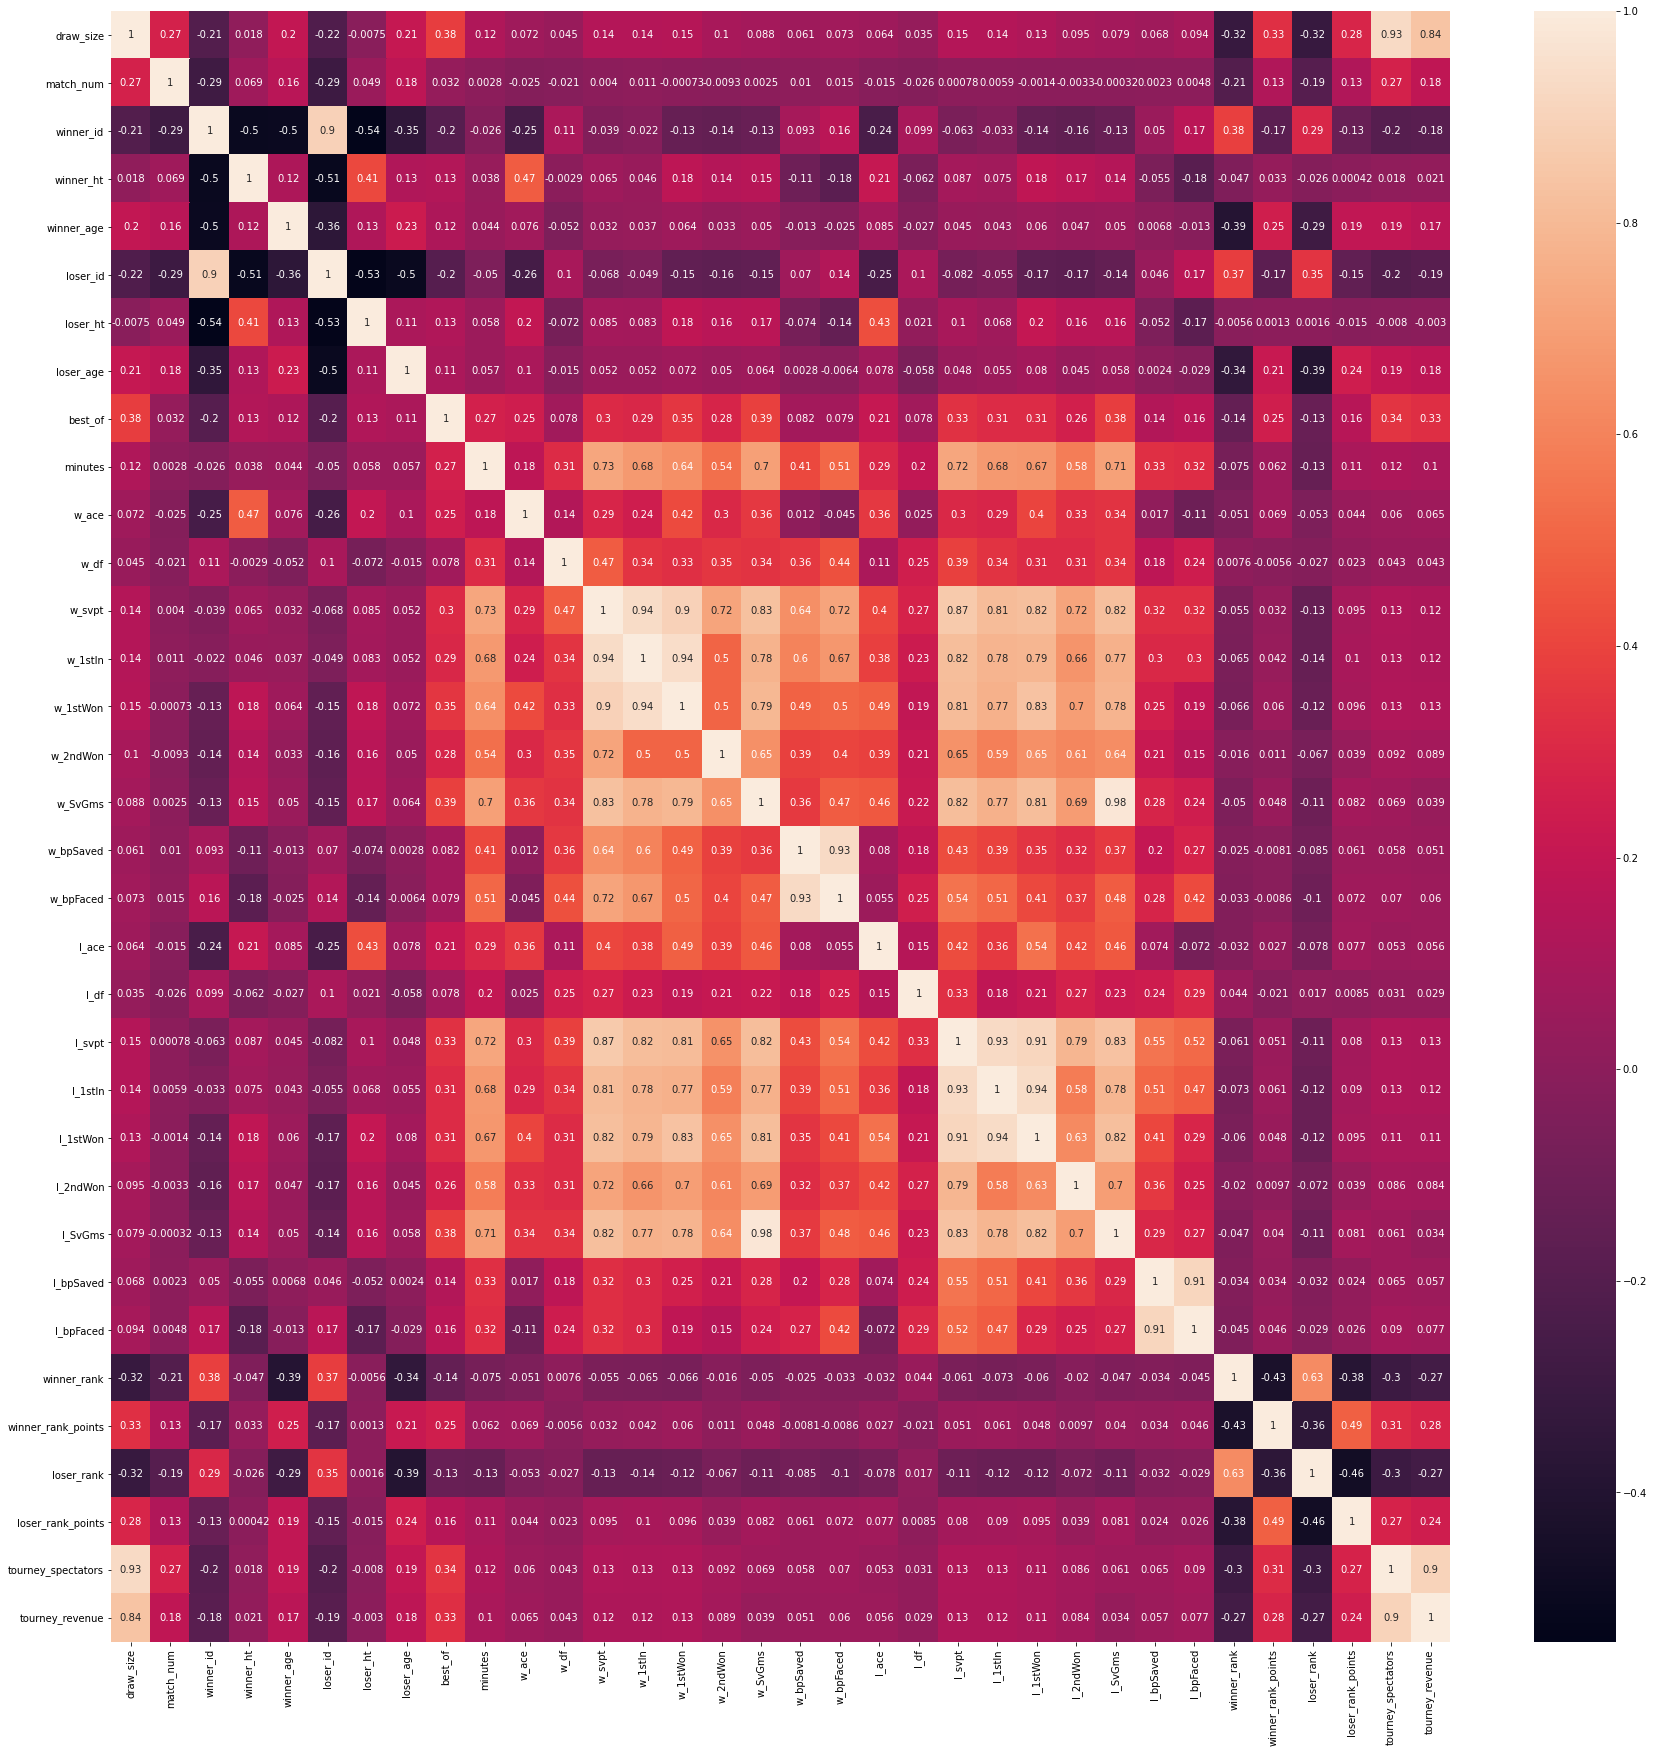

In [8]:
fig, ax = plt.subplots(figsize=(30, 30))         # Sample figsize in inches
sn.heatmap(matrix, annot=True)
plt.show()

In [9]:
#print_simple_stat(df, 'w_SvGms') #103817
#print_simple_stat(df, 'l_SvGms') #103810 
#df_SvGms_linear = df[['w_SvGms', 'l_SvGms']]
#print(df_SvGms_linear.describe())

#df_SvGms_linear = df_SvGms_linear.interpolate(method='linear')
#print_simple_stat(df_SvGms_linear, 'w_SvGms') #0
#print_simple_stat(df_SvGms_linear, 'l_SvGms') #0
#print(df_SvGms_linear.describe())

#df_SvGms_polynomial = df[['w_SvGms', 'l_SvGms']].interpolate(method='polynomial', order=2)
#print_simple_stat(df_SvGms_polynomial, 'w_SvGms') 
#print_simple_stat(df_SvGms_polynomial, 'l_SvGms') 
#print(df_SvGms_polynomial.describe())

# the linear interpolation does the most working fitting
#df[['w_SvGms', 'l_SvGms']] = df_SvGms_linear

### w_SvGms and l_SvGms
In a tennis match, players alternate the service, so a player serves about an half of sets. If we sum score, we obtain the total number of sets played. We define a new attribute SvGms and deletes w_SvGms and l_SvGms

In [10]:
#find the number of sets played in each match
score = df.score.replace( {'[(]\d[)]' : '',
                           '[(]\d\d[)]' : '',
                           '\[.' : '',
                           '-' : ' ',
                           '[&a-zA-z\/,;]' : '',
                          }, 
                         regex = True)
score.dropna(inplace = True)
score = score.apply(lambda x: [int(word) for word in x.split() if word.isdigit()])
score = score.apply(lambda x: sum(x))
score = pd.DataFrame(score)
score.set_axis(['SvGms'], axis = 1, inplace = True)
#create the new attribute SvGms and delete w_SvGms and l_SvGms
df = pd.merge(df, score, how = 'left', left_index=True, right_index=True)
del df['w_SvGms']
del df['l_SvGms']

In [11]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_gender,loser_gender,SvGms
0,2019-M020,Brisbane,Hard,32.00,A,2018-12-31,300.00,105453.00,NaN,Kei Nishikori,R,178.00,JPN,95.00,106421.00,NaN,Daniil Medvedev,R,198.00,RUS,22.00,6-4 3-6 6-2,3.00,F,124.00,3.00,3.00,77.00,44.00,31.00,17.00,3.00,6.00,8.00,6.00,100.00,54.00,34.00,20.00,10.00,15.00,9.00,3590.00,16.00,1977.00,3928.00,742618.69,M,M,27.00
1,2019-M020,Brisbane,Hard,32.00,A,2018-12-31,299.00,106421.00,NaN,Daniil Medvedev,R,198.00,RUS,22.00,104542.00,PR,Jo-Wilfried Tsonga,R,188.00,FRA,33.00,7-6(6) 6-2,3.00,SF,82.00,10.00,1.00,52.00,33.00,28.00,14.00,0.00,1.00,17.00,2.00,77.00,52.00,36.00,7.00,10.00,13.00,16.00,1977.00,239.00,200.00,3928.00,742618.69,M,NaN,21.00
2,2019-M020,Brisbane,Hard,32.00,A,2018-12-31,298.00,105453.00,NaN,Kei Nishikori,R,178.00,JPN,29.00,104871.00,NaN,Jeremy Chardy,R,188.00,FRA,31.00,6-2 6-2,3.00,SF,66.00,2.00,2.00,47.00,33.00,26.00,9.00,2.00,2.00,10.00,3.00,46.00,27.00,15.00,6.00,1.00,5.00,9.00,3590.00,40.00,1050.00,3928.00,742618.69,M,M,16.00
3,2019-M020,Brisbane,Hard,32.00,A,2018-12-31,297.00,104542.00,PR,Jo-Wilfried Tsonga,R,188.00,FRA,33.00,200282.00,NaN,Alex De Minaur,R,183.00,AUS,19.00,6-4 7-6(2),3.00,QF,106.00,12.00,2.00,68.00,43.00,34.00,15.00,4.00,5.00,1.00,2.00,81.00,60.00,38.00,9.00,4.00,6.00,239.00,200.00,31.00,1298.00,3928.00,742618.69,NaN,M,23.00
4,2019-M020,Brisbane,Hard,32.00,A,2018-12-31,296.00,106421.00,NaN,Daniil Medvedev,R,198.00,RUS,22.00,105683.00,NaN,Milos Raonic,R,196.00,CAN,28.00,6-7(2) 6-3 6-4,3.00,QF,129.00,12.00,3.00,105.00,68.00,48.00,25.00,8.00,8.00,29.00,5.00,94.00,56.00,46.00,19.00,2.00,4.00,16.00,1977.00,18.00,1855.00,3928.00,742618.69,M,M,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186068,2020-W-ITF-USA-48A-2020,W25 Orlando FL,Hard,32.00,25,2020-11-09,204.00,215794.00,WC,Hurricane Tyra Black,R,NaN,USA,19.00,222081.00,NaN,Eleana Yu,R,NaN,USA,16.00,7-6(1) 6-1,3.00,Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,598.00,57.00,1216.00,6.00,2312.00,471620.95,F,F,20.00
186069,2020-W-ITF-USA-48A-2020,W25 Orlando FL,Hard,32.00,25,2020-11-09,205.00,210754.00,NaN,Vivian Heisen,U,NaN,GER,26.00,220723.00,NaN,Jessica Livianu,R,NaN,USA,22.00,2-6 6-2 10-3,3.00,Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429.00,102.00,729.00,35.00,2312.00,471620.95,F,F,29.00
186070,2020-W-ITF-USA-48A-2020,W25 Orlando FL,Hard,32.00,25,2020-11-09,206.00,211874.00,NaN,Victoria Rodriguez,U,NaN,MEX,25.00,202478.00,NaN,Tara Moore,R,NaN,GBR,28.00,6-2 7-6(8),3.00,Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,643.00,48.00,454.00,93.00,2312.00,471620.95,F,F,21.00
186071,2020-W-ITF-USA-48A-2020,W25 Orlando FL,Hard,32.00,25,2020-11-09,207.00,213789.00,NaN,Katarina Jokic,U,NaN,BIH,22.00,205922.00,NaN,Chanelle Van Nguyen,U,NaN,USA,26.00,6-4 6-2,3.00,Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,923.00,17.00,627.00,51.00,2312.00,471620.95,F,F,18.00


### w_svpt w_1stIn and  l_svpt l_1stIn
We try to discover values of svpt and 1stIn using interpolation with SvGms

In [12]:
#we try different methods of interpolation: linear and polynomial
#let's see the distribution before interpolation
print_simple_stat(df, 'w_svpt') #103818
print_simple_stat(df, 'w_1stIn') #103818
#print_simple_stat(df, 'w_1stWon') #103816
df_linear = df[['w_svpt', 'w_1stIn', 'SvGms']]
print(df_linear.describe())

#interpolate and see how change distribution
df_linear = df_linear.interpolate(method='linear') #linear interpolation
print_simple_stat(df_linear, 'w_svpt') #0
print_simple_stat(df_linear, 'w_1stIn') #0
#print_simple_stat(df_linear, 'w_1stWon') #0
print(df_linear.describe())
df_polynomial = df[['w_svpt', 'w_1stIn', 'SvGms']].interpolate(method='polynomial', order=2) #polynomial
print_simple_stat(df_polynomial, 'w_svpt') 
print_simple_stat(df_polynomial, 'w_1stIn') 
#print_simple_stat(df_polynomial, 'w_1stWon') 
print(df_polynomial.describe())
print_simple_stat(df, 'l_svpt') #103813 
print_simple_stat(df, 'l_1stIn') #103824 
#print_simple_stat(df, 'l_1stWon') #103817
df_linear2 = df[['l_svpt', 'l_1stIn', 'SvGms']]
print(df_linear2.describe())
df_linear2 = df_linear2.interpolate(method='linear')
print_simple_stat(df_linear2, 'l_svpt') #0
print_simple_stat(df_linear2, 'l_1stIn') #0
#print_simple_stat(df_linear2, 'l_1stWon') #0
print(df_linear2.describe())
df_polynomial2 = df[['l_svpt', 'l_1stIn', 'SvGms']].interpolate(method='polynomial', order=2)
print_simple_stat(df_polynomial2, 'l_svpt') 
print_simple_stat(df_polynomial2, 'l_1stIn') 
#print_simple_stat(df_polynomial2, 'l_1stWon') 
print(df_polynomial.describe())

# the linear interpolation does the most working fitting
df[['w_svpt', 'w_1stIn', 'SvGms']] = df_linear
df[['l_svpt', 'l_1stIn', 'SvGms']] = df_linear2 

#take only integer part
df[['w_svpt', 'w_1stIn']], rest = divmod(df[['w_svpt', 'w_1stIn']], 1)
df[['l_svpt', 'l_1stIn']], rest = divmod(df[['l_svpt', 'l_1stIn']], 1) 

w_svpt null_values:	103782
w_1stIn null_values:	103782
        w_svpt  w_1stIn     SvGms
count 81982.00 81982.00 185595.00
mean     71.30    44.27     21.15
std      25.53    16.95      6.80
min       0.00     0.00      0.00
25%      53.00    33.00     16.00
50%      67.00    42.00     20.00
75%      87.00    54.00     26.00
max    1957.00  1330.00     99.00
w_svpt null_values:	0
w_1stIn null_values:	0
         w_svpt   w_1stIn     SvGms
count 185764.00 185764.00 185764.00
mean      69.56     45.61     21.15
std       21.71     14.73      6.80
min        0.00      0.00      0.00
25%       54.00     35.00     16.00
50%       62.74     42.00     20.00
75%       86.00     61.00     26.00
max     1957.00   1330.00     99.00
w_svpt null_values:	8569
w_1stIn null_values:	8569
          w_svpt    w_1stIn     SvGms
count  177195.00  177195.00 185764.00
mean   -13077.96   -4506.94     21.15
std     81571.12   64944.72      6.80
min   -223244.93 -149637.36     -1.86
25%    -35820.81   -7721.45  

### breakpoints 
try to handle missing values with interpolation

In [13]:
"""
print_simple_stat(df, 'w_bpSaved') #103813
print_simple_stat(df, 'w_bpFaced') #103816
df_linear = df[['w_bpSaved', 'w_bpFaced']]
print(df_linear.describe())
df_linear = df_linear.interpolate(method='linear')
print_simple_stat(df_linear, 'w_bpSaved') #0
print_simple_stat(df_linear, 'w_bpFaced') #0
print(df_linear.describe())
df_polynomial = df[['w_bpSaved', 'w_bpFaced']].interpolate(method='polynomial', order=2)
print_simple_stat(df_polynomial, 'w_bpSaved') #
print_simple_stat(df_polynomial, 'w_bpFaced') #
print(df_polynomial.describe())

print_simple_stat(df, 'l_bpSaved') #103817
print_simple_stat(df, 'l_bpFaced') #103822 
df_linear2 = df[['l_bpSaved', 'l_bpFaced']]
print(df_linear2.describe())
df_linear2 = df_linear2.interpolate(method='linear')
print_simple_stat(df_linear2, 'l_bpSaved') #0
print_simple_stat(df_linear2, 'l_bpFaced') #0
print(df_linear2.describe())
df_polynomial2 = df[['l_bpSaved', 'l_bpFaced']].interpolate(method='polynomial', order=2)
print_simple_stat(df_polynomial2, 'l_bpSaved') #
print_simple_stat(df_polynomial2, 'l_bpFaced') #
print(df_polynomial2.describe())

# the linear interpolation does the most working fitting
df[['w_bpSaved', 'w_bpFaced']] = df_linear 
df[['l_bpSaved', 'l_bpFaced']] = df_linear2

df[['w_bpSaved', 'w_bpFaced']], rest = divmod(df[['w_bpSaved', 'w_bpFaced']], 1)
df[['l_bpSaved', 'l_bpFaced']], rest = divmod(df[['l_bpSaved', 'l_bpFaced']], 1) 
"""

winner_bpSaved_mean = _fillna_(df, 'winner_name', 'w_bpSaved', 'mean') #
winner_bpSaved_median = _fillna_(df, 'winner_name', 'w_bpSaved', 'median') #
winner_bpFaced_mean = _fillna_(df, 'winner_name', 'w_bpFaced', 'mean') #
winner_bpFaced_median = _fillna_(df, 'winner_name', 'w_bpFaced', 'median') #

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_bpSaved'] = df['w_bpSaved'].fillna(df.groupby('winner_name')['w_bpSaved'].transform('median'))
df['w_bpSaved'] = round(df['w_bpSaved'], 0)
df['w_bpFaced'] = df['w_bpFaced'].fillna(df.groupby('winner_name')['w_bpFaced'].transform('median'))
df['w_bpFaced'] = round(df['w_bpFaced'], 0)

loser_bpSaved_mean =  _fillna_(df, 'loser_name', 'l_bpSaved', 'mean')
loser_bpSaved_median =  _fillna_(df, 'loser_name', 'l_bpSaved', 'median') #
loser_bpFaced_mean =  _fillna_(df, 'loser_name', 'l_bpFaced', 'mean')
loser_bpFaced_median =  _fillna_(df, 'loser_name', 'l_bpFaced', 'median') #

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_bpSaved'] = df['l_bpSaved'].fillna(df.groupby('loser_name')['l_bpSaved'].transform('median'))
df['l_bpSaved'] = round(df['l_bpSaved'], 0)
df['l_bpFaced'] = df['l_bpFaced'].fillna(df.groupby('loser_name')['l_bpFaced'].transform('median'))
df['l_bpFaced'] = round(df['l_bpFaced'], 0)


w_bpSaved null_values:	103782
count   81982.00
mean        3.54
std         3.11
min         0.00
25%         1.00
50%         3.00
75%         5.00
max       209.00
Name: w_bpSaved, dtype: float64
w_bpSaved null_values:	55142
count   130622.00
mean         3.79
std          2.67
min          0.00
25%          2.00
50%          4.00
75%          5.00
max        209.00
Name: w_bpSaved, dtype: float64
w_bpSaved null_values:	103782
count   81982.00
mean        3.54
std         3.11
min         0.00
25%         1.00
50%         3.00
75%         5.00
max       209.00
Name: w_bpSaved, dtype: float64
w_bpSaved null_values:	55142
count   130622.00
mean         3.63
std          2.68
min          0.00
25%          2.00
50%          3.00
75%          5.00
max        209.00
Name: w_bpSaved, dtype: float64
w_bpFaced null_values:	103782
count   81982.00
mean        5.40
std         4.20
min         0.00
25%         2.00
50%         5.00
75%         8.00
max       266.00
Name: w_bpFaced, dtype: floa

### w_ace, w_1stwon, w_2ndwon, w_df, l_ace, l_1stwon, l_2ndwon, l_df
these attributes depend on player's skills, so we group by name and approximate missing value with mean or median. We decide the metric looking the std.

#### aces

In [14]:
winner_ace_mean = _fillna_(df, 'winner_name', 'w_ace', 'mean') #55142
winner_ace_median = _fillna_(df, 'winner_name', 'w_ace', 'median') #55142

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_ace'] = df['w_ace'].fillna(df.groupby('winner_name')['w_ace'].transform('median'))
df['w_ace'] = round(df['w_ace'], 0)

loser_ace_mean =  _fillna_(df, 'loser_name', 'l_ace', 'mean')
loser_ace_median =  _fillna_(df, 'loser_name', 'l_ace', 'median') #56825

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_ace'] = df['l_ace'].fillna(df.groupby('loser_name')['l_ace'].transform('median'))
df['l_ace'] = round(df['l_ace'], 0)

w_ace null_values:	103782
count   81982.00
mean        4.82
std         4.39
min         0.00
25%         2.00
50%         4.00
75%         7.00
max        75.00
Name: w_ace, dtype: float64
w_ace null_values:	55142
count   130622.00
mean         3.92
std          3.86
min          0.00
25%          1.00
50%          3.00
75%          5.00
max         75.00
Name: w_ace, dtype: float64
w_ace null_values:	103782
count   81982.00
mean        4.82
std         4.39
min         0.00
25%         2.00
50%         4.00
75%         7.00
max        75.00
Name: w_ace, dtype: float64
w_ace null_values:	55142
count   130622.00
mean         3.82
std          3.89
min          0.00
25%          1.00
50%          3.00
75%          5.00
max         75.00
Name: w_ace, dtype: float64
l_ace null_values:	103782
count   81982.00
mean        3.54
std         3.83
min         0.00
25%         1.00
50%         2.00
75%         5.00
max        67.00
Name: l_ace, dtype: float64
l_ace null_values:	56825
count   128

In [15]:
# we still have null values
print_simple_stat(df, 'w_ace') #103818 --> 55142
print_simple_stat(df, 'l_ace') #103815 --> 56825

w_ace null_values:	55142
l_ace null_values:	56825


#### first won and second won

In [16]:
winner_1stwon_mean = _fillna_(df,'winner_name', 'w_1stWon', 'mean') 
winner_1stwon_median = _fillna_(df,'winner_name', 'w_1stWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_1stWon'] = df['w_1stWon'].fillna(df.groupby('winner_name')['w_1stWon'].transform('median'))
df['w_1stWon'] = round(df['w_1stWon'], 0)

loser_1stwon_mean = _fillna_(df,'loser_name', 'l_1stWon', 'mean') 
loser_1stwon_median =  _fillna_(df,'loser_name', 'l_1stWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_1stWon'] = df['l_1stWon'].fillna(df.groupby('loser_name')['l_1stWon'].transform('median'))
df['l_1stWon'] = round(df['l_1stWon'], 0)

w_1stWon null_values:	103782
count   81982.00
mean       32.14
std        11.41
min         0.00
25%        24.00
50%        30.00
75%        38.00
max       836.00
Name: w_1stWon, dtype: float64
w_1stWon null_values:	55142
count   130622.00
mean        31.06
std          9.62
min          0.00
25%         25.00
50%         30.00
75%         35.00
max        836.00
Name: w_1stWon, dtype: float64
w_1stWon null_values:	103782
count   81982.00
mean       32.14
std        11.41
min         0.00
25%        24.00
50%        30.00
75%        38.00
max       836.00
Name: w_1stWon, dtype: float64
w_1stWon null_values:	55142
count   130622.00
mean        30.79
std          9.71
min          0.00
25%         25.00
50%         29.00
75%         35.00
max        836.00
Name: w_1stWon, dtype: float64
l_1stWon null_values:	103782
count   81982.00
mean       28.05
std        12.27
min         0.00
25%        19.00
50%        26.00
75%        35.00
max       532.00
Name: l_1stWon, dtype: float64
l_1stW

In [17]:
winner_2ndwon_mean = _fillna_(df,'winner_name', 'w_2ndWon', 'mean') 
winner_2ndwon_median = _fillna_(df,'winner_name', 'w_2ndWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_2ndWon'] = df['w_2ndWon'].fillna(df.groupby('winner_name')['w_2ndWon'].transform('median'))
df['w_2ndWon'] = round(df['w_2ndWon'], 0)

loser_2ndwon_mean = _fillna_(df,'loser_name', 'l_2ndWon', 'mean') 
loser_2ndwon_median =  _fillna_(df,'loser_name', 'l_2ndWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_2ndWon'] = df['l_2ndWon'].fillna(df.groupby('loser_name')['l_2ndWon'].transform('median'))
df['l_2ndWon'] = round(df['l_2ndWon'], 0)

w_2ndWon null_values:	103782
count   81982.00
mean       14.46
std         5.94
min         0.00
25%        10.00
50%        14.00
75%        18.00
max       304.00
Name: w_2ndWon, dtype: float64
w_2ndWon null_values:	55142
count   130622.00
mean        13.85
std          5.11
min          0.00
25%         11.00
50%         13.00
75%         16.00
max        304.00
Name: w_2ndWon, dtype: float64
w_2ndWon null_values:	103782
count   81982.00
mean       14.46
std         5.94
min         0.00
25%        10.00
50%        14.00
75%        18.00
max       304.00
Name: w_2ndWon, dtype: float64
w_2ndWon null_values:	55142
count   130622.00
mean        13.73
std          5.14
min          0.00
25%         11.00
50%         13.00
75%         16.00
max        304.00
Name: w_2ndWon, dtype: float64
l_2ndWon null_values:	103782
count   81982.00
mean       12.72
std         6.32
min         0.00
25%         8.00
50%        12.00
75%        16.00
max       399.00
Name: l_2ndWon, dtype: float64
l_2ndW

#### double fault

In [18]:
winner_df_mean = _fillna_(df,'winner_name', 'w_df', 'mean') 
winner_df_median = _fillna_(df,'winner_name', 'w_df', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_df'] = df['w_df'].fillna(df.groupby('winner_name')['w_df'].transform('median'))
df['w_df'] = round(df['w_df'], 0)


print_stat(df,'l_df') #is done the same with the l_ace
loser_df_mean = _fillna_(df,'loser_name', 'l_df', 'mean') 
loser_df_median =  _fillna_(df,'loser_name', 'l_df', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_df'] = df['l_df'].fillna(df.groupby('loser_name')['l_df'].transform('median'))
df['l_df'] = round(df['l_df'], 0)

w_df null_values:	103782
count   81982.00
mean        2.86
std         2.42
min         0.00
25%         1.00
50%         2.00
75%         4.00
max       114.00
Name: w_df, dtype: float64
w_df null_values:	55142
count   130622.00
mean         3.14
std          2.29
min          0.00
25%          2.00
50%          3.00
75%          4.00
max        114.00
Name: w_df, dtype: float64
w_df null_values:	103782
count   81982.00
mean        2.86
std         2.42
min         0.00
25%         1.00
50%         2.00
75%         4.00
max       114.00
Name: w_df, dtype: float64
w_df null_values:	55142
count   130622.00
mean         3.04
std          2.29
min          0.00
25%          1.00
50%          3.00
75%          4.00
max        114.00
Name: w_df, dtype: float64
l_df null_values:	103782
count   81982.00
mean        3.61
std         2.61
min         0.00
25%         2.00
50%         3.00
75%         5.00
max       114.00
Name: l_df, dtype: float64
l_df null_values:	103782
count   81982.00
mean

In [19]:
print_simple_stat(df, 'w_df') #103816 --> 55142
print_simple_stat(df, 'l_df') #103809 --> 56825

w_df null_values:	55142
l_df null_values:	56825


## Entries
By visualizing the distribution of winner_entry/loser_entry we note that some values are present only with the losers and vice versa, some are present only with the winners. 
But they seem to be not able to help in deducing missing values.

(?) There is some relation with the ranking of the player to discover

<AxesSubplot:title={'center':'Distribution of winner_entry'}, xlabel='winner_entry'>

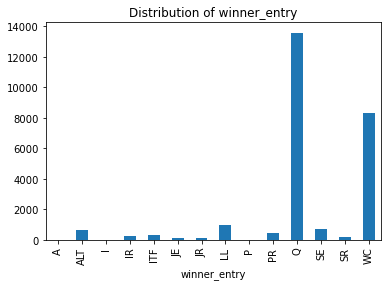

In [20]:
lf = df.groupby(['winner_entry']).size()
lf.plot(
    title="Distribution of winner_entry",
    kind='bar')

<AxesSubplot:title={'center':'Distribution of loser_entry'}, xlabel='loser_entry'>

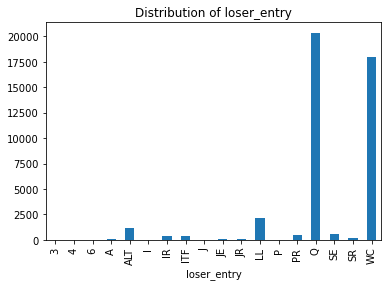

In [21]:
rf = df.groupby(['loser_entry']).size()
rf.plot(
    title="Distribution of loser_entry",
    kind='bar')

In [22]:
# ACHTUNG
print_simple_stat(df, 'winner_entry') #159958
print_simple_stat(df, 'loser_entry') #141684

# since they are much more than the half of all the dataset rows we decide to remove both the 2 columns
# moreover we couldn't do any assumption to try to deduce something more
#df = df.drop('winner_entry', 1)
#df = df.drop('loser_entry', 1)

winner_entry null_values:	159958
loser_entry null_values:	141684


## Hand
We see again the graph the used hands. By which we could also see which are the most used values and assign to the missing ones, but we avoid this way.

<AxesSubplot:title={'center':'Distribution of the hand used on matches and their gender'}, xlabel='winner_hand,loser_hand,winner_gender'>

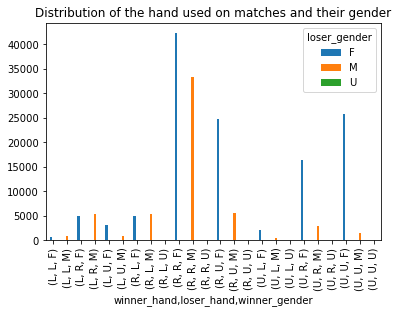

In [23]:
lf = df.groupby([ 'winner_hand', 'loser_hand', 'winner_gender', 'loser_gender']).size()
lf = lf.unstack()
lf.plot(
    title="Distribution of the hand used on matches and their gender", 
    kind='bar')

In [24]:
# this is the attribute with less empty values

print_simple_stat(df, 'winner_hand') #16

df_names = df[ df.winner_hand.isnull() & df.winner_name.notnull() ].winner_name.unique()
#Hady Habib, id: 200273.0
#Jose Olivares, id: 144773.0, we get a single row
#Nicolas Xiviller, id: 200537.0, we get a single row
#Sebastian Arcila, id: 200619.0, is not a so famous tennis player
#Ignacio Garcia, id: 200620.0, is a footballer
#Bruno Britez, id: 200621.0
#Jean Jacques Rakotohasy, id: 200272.0
for i in df_names: # for each of them we try to find a possible match in which they were saved with his/her hand
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_name==i)] 
    if (df_match.size != 0):
        print(df_match) #never enters -> never present 
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_name==i)] 
    if (df_match.size != 0):
        print(df_match) #never enters -> never present 
    
df_ids = df[ df.winner_hand.isnull() & df.winner_name.notnull() ].winner_id.unique()
for i in df_ids:
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_id==i)]     
    if (df_match.size != 0):
        print(df_match) 
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_id==i)] 
    if (df_match.size != 0):
        print(df_match) 

# we weren't able to find a match so we cannot fill empty values here, we think that they are, more porbably, outliers


# we check the same also for the loser_hand
print_simple_stat(df, 'loser_hand') #71

df_names = df[ df.loser_hand.isnull() & df.loser_name.notnull() ].loser_name.unique()
# they are all the previous, without Jean Jacques Rakotohasy
#Hady Habib --> already checked
#Sebastian Dominguez
#Xavier Lawrence
#Minjong Park
#Ainius Sabaliauskas
#Ignacio Garcia --> already checked
#Alex Diaz
#Sebastian Arcila --> already checked
#Christophe Tholl
#Yasitha De Silva
#Linh Giang Trinh
#Nicolas Xiviller --> already checked
#Gianmarco De Santis
#Ross Watson
#Beruk Tsegai
#Giuseppe Tresca
#Filippo Moggian
#Jose Olivares --> already checked
#Michael Ogden
#Dac Tien Nguyen
#Rong Ma
#Bruno Britez --> already checked
#William Kirkman
#Jerome Kym
#Peter Bertran
#Adam Hornby
#Hernando Jose Escurra Isnardi
#Sebastian Quiros
#Alex Knaff
#Illia Biloborodko
#Matthew Foster Estwick
#Isabel Pascual Montalvo

for i in df_names:    
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_name==i)] 
    if (df_match.size != 0):
        print(df_match) 
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_name==i)] 
    if (df_match.size != 0):
        print(df_match) 
df_ids = df[ df.loser_hand.isnull() & df.loser_name.notnull() ].loser_id.unique()
for i in df_ids:    
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_id==i)] 
    if (df_match.size != 0):
        print(df_match) 
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_id==i)] 
    if (df_match.size != 0):
        print(df_match) 

df['winner_hand']=df['winner_hand'].fillna('U')
df['loser_hand']=df['loser_hand'].fillna('U')

winner_hand null_values:	16
loser_hand null_values:	71


In [25]:
print_simple_stat(df, 'winner_hand')
print_simple_stat(df, 'loser_hand')

winner_hand null_values:	0
loser_hand null_values:	0


## Minutes
According to the distribution of the matches duration along the years, we note that there are a lot of matches played with less than 1 hour, 1 hour and some of 2 hours. The bad thing is that there are also a lot of NaN values

<AxesSubplot:title={'center':'Distribution of the duration of the matches during the years'}>

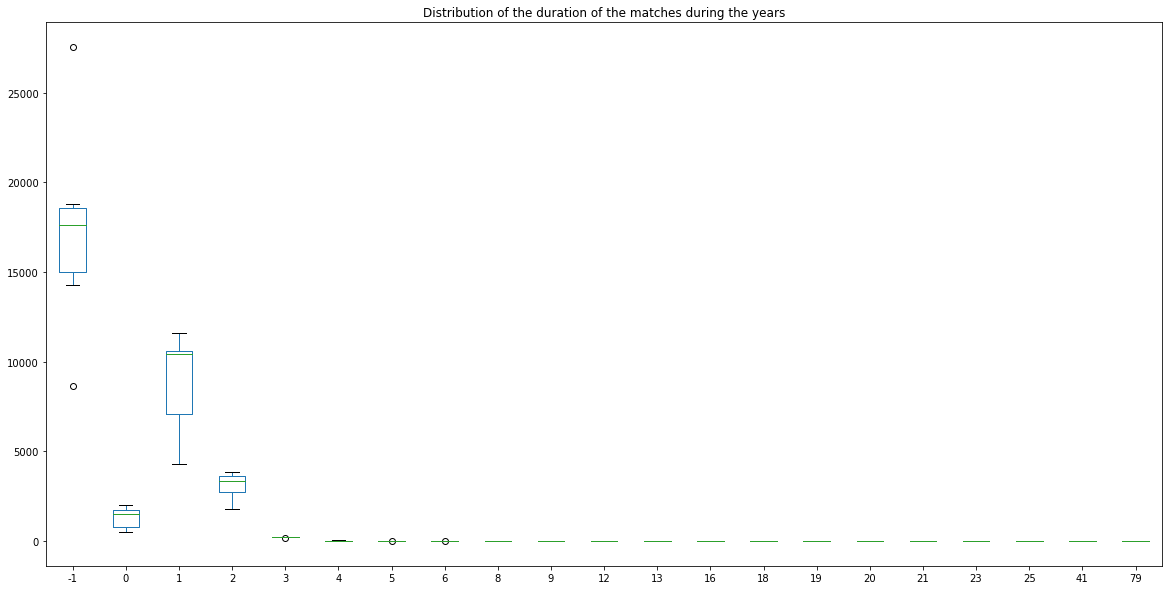

In [26]:
minutes = df['minutes']
minutes = pd.to_numeric(minutes, errors='coerce') #for removing all non-numeric values use to_numeric with parameter errors='coerce' - to replace non-numeric values to NaNs
minutes = minutes.fillna(-1)
minutes = minutes.astype(int) #Last convert values to ints:
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y-%m-%d')
lf = df.groupby([ [x.year for x in df.tourney_date], [ int( x // 60) for x in minutes]]).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of the duration of the matches during the years", 
    kind='box')

In [27]:
print_stat(df, 'minutes') #104430

# in the already seen graph, the majority of the matches has happened within 1 hour, even if we show the difference between the mean and median
# we decide to apply the amount of time of 60.00 minutes for the unknown values since it is the one with the better similar standard deviation 

var = df[['minutes']]
var['minutes'] = var['minutes'].fillna(var.minutes.mean())
print_stat(var, 'minutes')

var2 = df[['minutes']]
var2['minutes'] = var2['minutes'].fillna(var2.minutes.median())
print_stat(var2, 'minutes')

var3 = df[['minutes']]
var3['minutes'] = var3['minutes'].fillna(60.00)
print_stat(var3, 'minutes') #0

df['minutes'] = var3['minutes']

minutes null_values:	104430
count   81334.00
mean       97.70
std        41.52
min         0.00
25%        72.00
50%        91.00
75%       119.00
max      4756.00
Name: minutes, dtype: float64
minutes null_values:	0
count   185764.00
mean        97.70
std         27.47
min          0.00
25%         97.70
50%         97.70
75%         97.70
max       4756.00
Name: minutes, dtype: float64
minutes null_values:	0
count   185764.00
mean        93.93
std         27.67
min          0.00
25%         91.00
50%         91.00
75%         91.00
max       4756.00
Name: minutes, dtype: float64
minutes null_values:	0
count   185764.00
mean        76.50
std         33.23
min          0.00
25%         60.00
50%         60.00
75%         85.00
max       4756.00
Name: minutes, dtype: float64


<AxesSubplot:title={'center':'Distribution of the duration of the matches during the years'}>

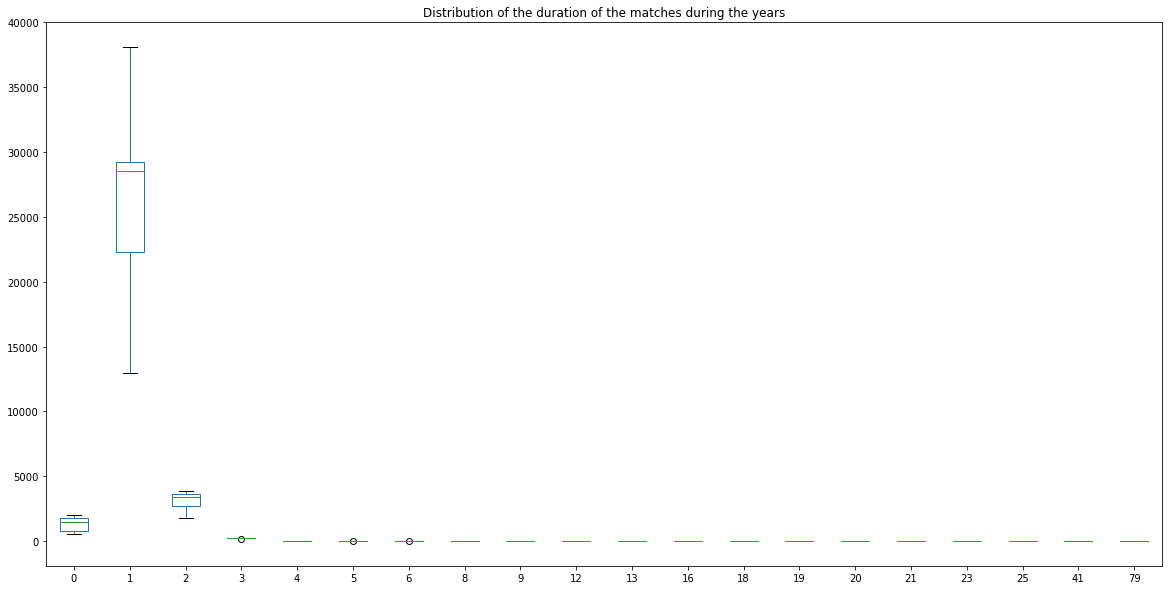

In [28]:
minutes = df['minutes']
minutes = pd.to_numeric(minutes, errors='coerce') #for removing all non-numeric values use to_numeric with parameter errors='coerce' - to replace non-numeric values to NaNs
minutes = minutes.fillna(-1)
minutes = minutes.astype(int) #Last convert values to ints:

lf = df.groupby([ [x.year for x in df.tourney_date], [ int( x // 60) for x in minutes]]).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of the duration of the matches during the years", 
    kind='box')

## Surface

By seeing again the surface graph we could choose to change the missing values respecting the distribution as indicated by the colors, but we avoided this since it could be done bringing errors. We simply kept them empty since the missing values are for matches happened in different places where we cannot be sure of the surface value.

<AxesSubplot:title={'center':'Distribution of the surface values according to the years of the tourney_date values'}>

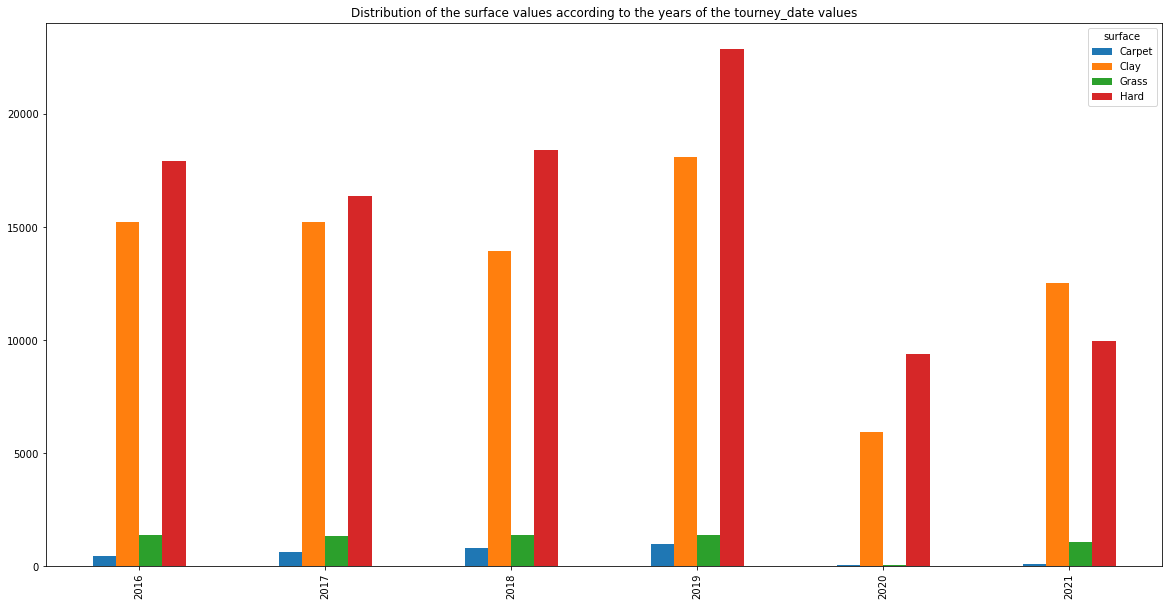

In [29]:
lf = df.groupby([ [x.year for x in df.tourney_date], 'surface']).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of the surface values according to the years of the tourney_date values", 
    kind='bar')

In [30]:
print_simple_stat(df, 'surface') #162

#df.groupby([ [x.year for x in df.tourney_date], df['surface'].isnull()]).size() #40 NaN in 2016 e 122 NaN in 2017

# they are competitions that have happened in different places so is not possile to resolve their knowledge 
# the only way to resolve them is by using an external resource as Google
# for that reason we leave them as NaN

tourney_ids = df[ df['surface'].isnull() ]

tourney_ids = tourney_ids.groupby(tourney_ids.tourney_id).size()
tourney_ids = pd.DataFrame(tourney_ids)
tourney_ids.reset_index(level=0, inplace=True)
tourney_ids.rename( columns={ 0 :'freq'}, inplace = True)
outliers = tourney_ids[tourney_ids['freq']>2]
print(outliers)

surface null_values:	162
                            tourney_id  freq
20   2017-M-DC-2017-G1-AM-M-PER-ECU-01     4
21   2017-M-DC-2017-G1-AO-M-NZL-IND-01     4
22   2017-M-DC-2017-G1-AO-M-TPE-CHN-01     4
23   2017-M-DC-2017-G1-AO-M-UZB-KOR-01     3
24  2017-M-DC-2017-G1-EPA-M-ISR-POR-01     4
25  2017-M-DC-2017-G1-EPA-M-ROU-BLR-01     4
26  2017-M-DC-2017-G1-EPA-M-SVK-HUN-01     3
27   2017-M-DC-2017-G2-AM-M-BAH-VEN-01     4
28   2017-M-DC-2017-G2-AM-M-BAR-PAR-01     4
29   2017-M-DC-2017-G2-AM-M-BOL-ESA-01     4
30   2017-M-DC-2017-G2-AM-M-MEX-GUA-01     3
31   2017-M-DC-2017-G2-AO-M-INA-PHI-01     4
32   2017-M-DC-2017-G2-AO-M-KUW-THA-01     3
33   2017-M-DC-2017-G2-AO-M-VIE-HKG-01     4
34  2017-M-DC-2017-G2-EPA-M-EST-RSA-01     4
35  2017-M-DC-2017-G2-EPA-M-FIN-GEO-01     4
36  2017-M-DC-2017-G2-EPA-M-LTU-MAD-01     4
37  2017-M-DC-2017-G2-EPA-M-MAR-DEN-01     4
38  2017-M-DC-2017-G2-EPA-M-MON-SLO-01     4
39  2017-M-DC-2017-G2-EPA-M-NOR-LAT-01     4
40  2017-M-DC-2017-G2-EPA-M-TU

In [31]:
print_simple_stat(df, 'score') #169
# we decide to don't change it since is not deducible from the other known values

score null_values:	169


## Gender
We consult again the graph in which we put in relation the gender and the level of the players. Thanks to it we decide that we can have only matches happening with players of the same gender. So, using this fact we can deduce the gender of the missing player, such as, if we know the gender of the winner then we can also know the gender of the loser, and vice versa.

<AxesSubplot:title={'center':'Distribution of tourney_level values according to the gender of the player'}, xlabel='Gender of the winner and loser player', ylabel='Counting'>

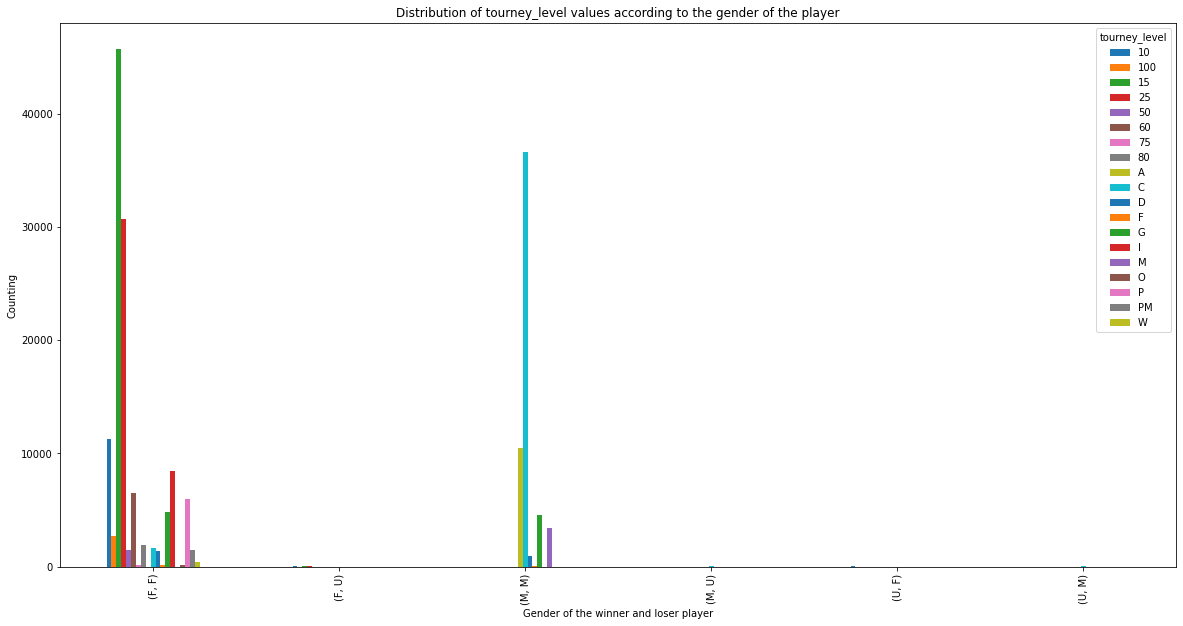

In [32]:
lf = df.groupby(['winner_gender', 'loser_gender', 'tourney_level']).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of tourney_level values according to the gender of the player", 
    xlabel="Gender of the winner and loser player",
    ylabel="Counting",
    kind='bar')

In [33]:
print_simple_stat(df, 'winner_gender') #2677

var = df[ df['winner_gender'].isnull()]
var['loser_gender']=var['loser_gender'].replace({'U': np.nan}, regex=True)
var = var[var['loser_gender'].notna()]

var = var.groupby(['winner_name']).loser_gender.unique()

var = pd.DataFrame(var)
var.reset_index(level=0, inplace=True)
#var.rename( columns={ 0 :'gender'}, inplace = True)

#print(var)

df[df.winner_name.isin(var['winner_name'])].winner_gender=df[df.winner_name.isin(var['winner_name'])].loser_gender.values
df[df.winner_name.isin(var['winner_name'])] = df[df.winner_name.isin(var['winner_name'])].assign(winner_gender=df[df.winner_name.isin(var['winner_name'])].loser_gender)
#print(df[df.winner_name.isin(var['winner_name'])].winner_gender)

#print(df[df['winner_name']=='Alona Fomina'])

winner_gender null_values:	2677


In [34]:
print_simple_stat(df, 'loser_gender') #2098

var = df[ df['loser_gender'].isnull()]
var['winner_gender']=var['winner_gender'].replace({'U': np.nan}, regex=True)
var = var[var['winner_gender'].notna()]

var = var.groupby(['loser_name']).winner_gender.unique()

var = pd.DataFrame(var)
var.reset_index(level=0, inplace=True)
#var.rename( columns={ 0 :'gender'}, inplace = True)

#print(var)

df[df.loser_name.isin(var['loser_name'])].loser_gender=df[df.loser_name.isin(var['loser_name'])].winner_gender.values
df[df.loser_name.isin(var['loser_name'])] = df[df.loser_name.isin(var['loser_name'])].assign(loser_gender=df[df.loser_name.isin(var['loser_name'])].winner_gender)
#print(df[df.loser_name.isin(var['loser_name'])].loser_gender)

loser_gender null_values:	2098


In [35]:
print_simple_stat(df, 'winner_gender') #2677 --> 89
print_simple_stat(df, 'loser_gender') #2098 --> 89

df['winner_gender']=df['winner_gender'].fillna('U')
df['loser_gender']=df['loser_gender'].fillna('U')

print_simple_stat(df, 'winner_gender') #2677 --> 0
print_simple_stat(df, 'loser_gender') #2098 --> 0

winner_gender null_values:	89
loser_gender null_values:	89
winner_gender null_values:	0
loser_gender null_values:	0


## Heights

In [36]:
# ACHTUNG
# as winner_entry and loser_entry we have quite the same amount of missing values 
# but before to decide to drop or not also these columns we make another check

print_stat(df,'winner_ht')
#w_ht = df[['winner_name', 'winner_ht']]
df['winner_ht'] = df['winner_ht'].fillna(df.groupby('winner_name')['winner_ht'].transform('mean'))
print_stat(df, 'winner_ht')

print_stat(df, 'loser_ht')
#l_ht = df[['loser_name', 'loser_ht']]
df['loser_ht'] = df['loser_ht'].fillna(df.groupby('loser_name')['loser_ht'].transform('mean'))
print_stat(df, 'loser_ht')
# we can solve only quite 2000 values for both winner_ht and loser_ht
# and since there remain again so much empty values as the winner_entry and loser_entry, 
# for the same reason as before, we decide to drop also these 2 columns

#df = df.drop('winner_ht',1)
#df = df.drop('loser_ht',1)

winner_ht null_values:	136474
count   49290.00
mean      181.41
std        11.63
min         2.00
25%       175.00
50%       183.00
75%       188.00
max       211.00
Name: winner_ht, dtype: float64
winner_ht null_values:	134362
count   51402.00
mean      180.98
std        12.08
min         2.00
25%       175.00
50%       182.00
75%       188.00
max       211.00
Name: winner_ht, dtype: float64
loser_ht null_values:	147438
count   38326.00
mean      181.57
std        10.82
min         2.00
25%       175.00
50%       183.00
75%       188.00
max       211.00
Name: loser_ht, dtype: float64
loser_ht null_values:	145968
count   39796.00
mean      181.16
std        11.38
min         2.00
25%       175.00
50%       183.00
75%       188.00
max       211.00
Name: loser_ht, dtype: float64


In [37]:
#We estimate the remaining heights according to mean, grouping by nationality and gender
w_ht = df[['winner_name', 'winner_ioc', 'winner_ht', 'winner_gender']]
w_ht.set_axis(['name', 'ioc', 'ht', 'gender'], axis = 1, inplace = True)
l_ht = df[['loser_name','loser_ioc', 'loser_ht', 'loser_gender']]
l_ht.set_axis(['name', 'ioc', 'ht', 'gender'], axis = 1, inplace = True)

player_ht = w_ht.append(l_ht)
player_ht.drop_duplicates(inplace = True)
#female players
female_ht = player_ht[player_ht.gender == 'F']
#print(female_ht.ht.isna().sum())
female_ht.ht.fillna(female_ht.groupby('ioc')['ht'].transform('mean'), inplace = True)
#print(female_ht.ht.isna().sum())

#male players
male_ht = player_ht[player_ht.gender == 'M']
#print(male_ht.ht.isna().sum())
male_ht.ht.fillna(male_ht.groupby('ioc')['ht'].transform('mean'), inplace = True)
#print(male_ht.ht.isna().sum())

#when we'll create the player profile we are interested in the last ht 
player_ht = female_ht.append(male_ht)
player_ht = player_ht.groupby('name').ht.max()
player_ht = pd.DataFrame(player_ht)
player_ht = player_ht.reset_index()

#fillna winner player
player_ht.set_axis(['winner_name', 'winner_ht'], axis = 1, inplace = True)
del df['winner_ht']
df = pd.merge(df, player_ht, how = 'left', on = 'winner_name')


#fillna loser player
player_ht.set_axis(['loser_name', 'loser_ht'], axis = 1, inplace = True)
del df['loser_ht']
df = pd.merge(df, player_ht, how = 'left', on = 'loser_name')

#del df ['loser_ht']
print('rows with winner ht Nan', df.winner_ht.isna().sum())
print('rows with loser ht Nan', df.loser_ht.isna().sum())

rows with winner ht Nan 13856
rows with loser ht Nan 15522


## Age

In [38]:
print_simple_stat(df, 'winner_age') #2828 --> 2810

var = df.groupby(['winner_name']).winner_age.unique()
var = pd.DataFrame(var)
var.reset_index(inplace=True)

#print(np.size(var.winner_age))
#var=var[var['winner_age']>1]

#in totale abbiamo 6 valori da salvare, il problema è come farlo in automatico? scegliamo di farlo manualmente per ogni caso
var = var.apply(lambda x: print(x['winner_name']) if ((x['winner_age'].size>1) and (np.argwhere(np.isnan(x['winner_age'])))) else np.nan, axis=1)
#--------------------------------------------------------------------------------------------------------------
#print(df[df['winner_name']=='Fitriani Sabatini']['tourney_date'])
df.at[173281, 'winner_age'] = 20.00
df.at[173355, 'winner_age'] = 20.00
df.at[173409, 'winner_age'] = 20.00
df.at[173474, 'winner_age'] = 20.00
df.at[173489, 'winner_age'] = 20.00
df.at[173500, 'winner_age'] = 20.00
#print(df[df['winner_name']=='Fitriani Sabatini']['winner_age'])
#--------------------------------------------------------------------------------------------------------------
#print(df[df['winner_name']=='Nana Kawagishi']['tourney_date'])
df.at[173937, 'winner_age'] = 21.00
df.at[173949, 'winner_age'] = 21.00
df.at[173961, 'winner_age'] = 21.00
df.at[173974, 'winner_age'] = 21.00
df.at[173999, 'winner_age'] = 21.00
df.at[174010, 'winner_age'] = 21.00    
#print(df[df['winner_name']=='Nana Kawagishi']['winner_age'])
#--------------------------------------------------------------------------------------------------------------
#print(df[df['winner_name']=='Sofia Nahiara Garcia']['tourney_date'])
df.at[163278, 'winner_age'] = 18.00
#print(df[df['winner_name']=='Sofia Nahiara Garcia']['winner_age'])
#--------------------------------------------------------------------------------------------------------------
#print(df[df['winner_name']=='Stanislava Bobrovnikova']['tourney_date'])
df.at[185224, 'winner_age'] = 17.00
df.at[174051, 'winner_age'] = 18.00
df.at[169934, 'winner_age'] = 18.00
#print(df[df['winner_name']=='Stanislava Bobrovnikova']['winner_age'])
#--------------------------------------------------------------------------------------------------------------
#print(df[df['winner_name']=='Valentina Lia']['tourney_date'])
df.at[169287, 'winner_age'] = 27.00
#print(df[df['winner_name']=='Valentina Lia']['winner_age'])
#--------------------------------------------------------------------------------------------------------------
#print(df[df['winner_name']=='Vanessa Ersoz']['tourney_date'])
df.at[180881, 'winner_age'] = 18.00
#print(df[df['winner_name']=='Vanessa Ersoz']['winner_age'])
#--------------------------------------------------------------------------------------------------------------

winner_age null_values:	2828
Fitriani Sabatini
Nana Kawagishi
Sofia Nahiara Garcia
Stanislava Bobrovnikova
Valentina Lia
Vanessa Ersoz


<ipython-input-38-04881300512d>:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  var = var.apply(lambda x: print(x['winner_name']) if ((x['winner_age'].size>1) and (np.argwhere(np.isnan(x['winner_age'])))) else np.nan, axis=1)


In [39]:
print_simple_stat(df, 'loser_age') #6501 --> 6474

var = df.groupby(['loser_name']).loser_age.unique()
var = pd.DataFrame(var)
var.reset_index(inplace=True)

var = var.apply(lambda x: print(x['loser_name']) if ((x['loser_age'].size>1) and (np.argwhere(np.isnan(x['loser_age'])))) else np.nan,axis=1)


#print(df[df['loser_name']=='Dominika Salkova']['tourney_date'])
df.at[139249, 'loser_age'] = 15.00
#print(df[df['loser_name']=='Dominika Salkova']['loser_age'])
#print('---------------------------------')
      
#print(df[df['loser_name']=='Eva Shaw']['tourney_date'])
df.at[180495, 'loser_age'] = 15.00
#print(df[df['loser_name']=='Eva Shaw']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Vanessa Ersoz']['tourney_date'])
df.at[180894, 'loser_age'] = 18.00
df.at[180939, 'loser_age'] = 18.00
df.at[184518, 'loser_age'] = 18.00
#print(df[df['loser_name']=='Vanessa Ersoz']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Valentina Lia']['tourney_date'])
df.at[169298, 'loser_age'] = 26.00
df.at[169391, 'loser_age'] = 26.00
#print(df[df['loser_name']=='Valentina Lia']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Stanislava Bobrovnikova']['tourney_date'])
df.at[169942, 'loser_age'] = 18.00
df.at[171366, 'loser_age'] = 18.00
df.at[174028, 'loser_age'] = 18.00
df.at[174065, 'loser_age'] = 18.00
df.at[185241, 'loser_age'] = 17.00
df.at[185303, 'loser_age'] = 17.00
#print(df[df['loser_name']=='Stanislava Bobrovnikova']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Sofia Nahiara Garcia']['tourney_date'])
df.at[163295, 'loser_age'] = 18.00
#print(df[df['loser_name']=='Sofia Nahiara Garcia']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Nana Kawagishi']['tourney_date'])
df.at[173900, 'loser_age'] = 21.00
df.at[173980, 'loser_age'] = 21.00
#print(df[df['loser_name']=='Nana Kawagishi']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Mia Kupres']['tourney_date'])
df.at[136958, 'loser_age'] = 16.00
df.at[136997, 'loser_age'] = 15.00
df.at[137042, 'loser_age'] = 16.00
#print(df[df['loser_name']=='Mia Kupres']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Holly Fischer']['tourney_date'])
df.at[143744, 'loser_age'] = 16.00
#print(df[df['loser_name']=='Holly Fischer']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Guy Stokman']['tourney_date'])
df.at[79951, 'loser_age'] = 17.00
#print(df[df['loser_name']=='Guy Stokman']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Fitriani Sabatini']['tourney_date'])
df.at[173223, 'loser_age'] = 20.00
df.at[173296, 'loser_age'] = 20.00
df.at[173368, 'loser_age'] = 20.00
df.at[173425, 'loser_age'] = 20.00
df.at[173451, 'loser_age'] = 20.00
#print(df[df['loser_name']=='Fitriani Sabatini']['loser_age'])
#print('---------------------------------')

#print(df[df['loser_name']=='Ekaterina Makarova']['tourney_date'])
#print(df[df['loser_name']=='Ekaterina Makarova']['loser_age'])
df.at[51441, 'loser_age'] = 28.00  
#print('---------------------------------')

loser_age null_values:	6501
Dominika Salkova
Ekaterina Makarova
Eva Shaw
Fitriani Sabatini
Guy Stokman
Holly Fischer
Mia Kupres
Nana Kawagishi
Sofia Nahiara Garcia
Stanislava Bobrovnikova
Valentina Lia
Vanessa Ersoz


<ipython-input-39-57707af66fd7>:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  var = var.apply(lambda x: print(x['loser_name']) if ((x['loser_age'].size>1) and (np.argwhere(np.isnan(x['loser_age'])))) else np.nan,axis=1)


In [40]:
print_simple_stat(df, 'w_2ndWon') #103819
print_simple_stat(df, 'l_2ndWon') #103816 
print_simple_stat(df, 'winner_rank') #19372
print_simple_stat(df, 'loser_rank') #35232
print_simple_stat(df, 'winner_rank_points') #19388
print_simple_stat(df, 'loser_rank_points') #35248

w_2ndWon null_values:	55142
l_2ndWon null_values:	56825
winner_rank null_values:	19372
loser_rank null_values:	35232
winner_rank_points null_values:	19388
loser_rank_points null_values:	35248


# Wrong_values

## tourney_name

In [74]:
df = pd.read_csv('dataset/matches_understanding.csv', index_col = 0)

In [75]:
df['tourney_name']=df['tourney_name'].str.upper()
dd = df.copy()
df['tourney_id']= df['tourney_id'].str[5:]
df['tourney_name']=df['tourney_name'].replace( {
    'MASTERS':'',
    ' \d*' : ' ',
    '[-._''+]' : ' ',
     "'": '',
    ' $ ' : '',
    'CH ':'',
    ' CH':'',        
    'SAN ':'ST.',
    'SAINT ':'ST.',
    'ST. ':'ST '
    
}, regex=True)

df['tourney_name']=df['tourney_name'].replace( {
    'SEVILLA':'SEVILLE',
    'ST BRIEUC':'ST.BRIEUC',
    'ST.BENEDETTO':'ST.BENEDETTO DEL TRONTO',
    'HOI MINH CITY':'HOI MINH',
    'LISBOA':'LISBON',
    'BENGALURU':'BANGALORE',
    'POPRAD TATRY':'POPRAD',
    
}, regex=True)

df['tourney_name']=df['tourney_name'].replace( {
    'DEL TRONTO DEL TRONTO':'DEL TRONTO',
    'RIO RIO ':'RIO ',
    
}, regex=True)


df['tourney_name'] = df['tourney_name'].str.rstrip()


TourneyId_name = df.groupby(['tourney_id']).tourney_name.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
TourneyId_name = TourneyId_name[TourneyId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

print(df[df.tourney_id.isin(TourneyId_name.index)].groupby(['tourney_id']).tourney_name.unique())
print(df[df.tourney_id.isin(TourneyId_name.index)].groupby(['tourney_id']).tourney_name.unique().count())
df['tourney_id']=dd['tourney_id']


tourney_id
0405               [TOKYO, JAPAN OPEN TOKYO, HIROSHIMA]
0637                      [CHAMPAIGN, CHAMPAIGN URBANA]
0703                                [STANFORD, ST.JOSE]
0741                           [EASTBOURNE, NOTTINGHAM]
0806                                [TORONTO, MONTREAL]
0808                       [SINGAPORE, SHENZHEN FINALS]
0891                                    [PUNE, CHENNAI]
1056                                     [TOKYO, OSAKA]
1091                                 [CALVIA, MALLORCA]
1094                                 [GSTAAD, LAUSANNE]
1096                                  [TAIPEI, HUA HIN]
3618                               [ASTANA, NUR SULTAN]
3627                                    [TODI, LAQUILA]
5016                       [BUCARAMANGA, FLORIDABLANCA]
5069                              [SARASOTA, BRADENTON]
581     [DOHA AUS OPEN QUALIES, DUBAI AUS OPEN QUALIES]
6963                              [MORELOS, CUERNAVACA]
7318                              [CO

## winner_name and loser_name

In [42]:
df['winner_name']=df['winner_name'].str.upper()
#df['winner_name']=df['winner_name'].replace({' ':'','  ':''}, regex=True)
WinnerId_name = df.groupby(['winner_name']).winner_id.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
WinnerId_name = WinnerId_name[WinnerId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_id.unique()



winner_name
ASTRID CIROTTE             [236980.0, 223401.0]
FITRIANI SABATINI          [221189.0, 239429.0]
KUAN YI LEE                [134120.0, 221745.0]
LIISA VARUL                [222914.0, 222915.0]
MARIA FERNANDA NAVARRO     [223367.0, 223287.0]
NANA KAWAGISHI             [221771.0, 244078.0]
SOFIA NAHIARA GARCIA       [220928.0, 236977.0]
STANISLAVA BOBROVNIKOVA    [221347.0, 225865.0]
VALENTINA LIA              [220334.0, 239415.0]
Name: winner_id, dtype: object

In [43]:
df['loser_name']=df['loser_name'].str.upper()
#df['loser_name']=df['loser_name'].replace({' ':'','  ':''}, regex=True)
LoserId_name = df.groupby(['loser_name']).loser_id.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
LoserId_name = LoserId_name[LoserId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_id.unique()



loser_name
ASTRID CIROTTE             [223401.0, 236980.0]
EKATERINA MAKAROVA         [201505.0, 223126.0]
ELENI FASOULA              [222942.0, 222943.0]
ELLIE MYERS                [222407.0, 240168.0]
EMILSE LUJAN RUIZ          [222646.0, 236974.0]
FITRIANI SABATINI          [221189.0, 239429.0]
GIUSEPPE TRESCA            [206834.0, 207982.0]
GUY STOKMAN                [206883.0, 207142.0]
HEI CHING CLAUDIA NG       [219835.0, 216586.0]
HOLLY FISCHER              [221142.0, 222228.0]
KUAN YI LEE                [134120.0, 221745.0]
LARA ONAL                  [224486.0, 223215.0]
LIISA VARUL                [222915.0, 222914.0]
MARIA FERNANDA NAVARRO     [223367.0, 223287.0]
MATYLDA BURYLO             [222845.0, 222066.0]
NANA KAWAGISHI             [221771.0, 244078.0]
SOFIA NAHIARA GARCIA       [220928.0, 236977.0]
STANISLAVA BOBROVNIKOVA    [221347.0, 225865.0]
VALENTINA LIA              [220334.0, 239415.0]
Name: loser_id, dtype: object

In [44]:
def compareAndSum(first,second):
    a=df[df['loser_id'] == first]['loser_id'].count()+df[df['winner_id'] == first]['winner_id'].count()
    b=df[df['loser_id'] == second]['loser_id'].count()+df[df['winner_id'] == second]['winner_id'].count()
    
    if a<b:
        return second
    else:
        return first

def changevalue(x,y,v):
    df['loser_id']=df['loser_id'].replace({x:v}, regex=True)
    df['winner_id']=df['winner_id'].replace({x:v}, regex=True)
    df['loser_id']=df['loser_id'].replace({y:v}, regex=True)
    df['winner_id']=df['winner_id'].replace({y:v}, regex=True)

In [45]:
#ASTRID CIROTTE             [223401.0, 236980.0]
values=compareAndSum(223401.0,236980.0)
changevalue(223401.0,236980.0,values)

#EKATERINA MAKAROVA         [201505.0, 223126.0]
values=compareAndSum(201505.0,223126.0)
changevalue(201505.0,223126.0,values)

#ELENI FASOULA              [222942.0, 222943.0]
values=compareAndSum(222942.0,222943.0)
changevalue(222942.0,222943.0,values)

#FITRIANI SABATINI          [221189.0, 239429.0]
values=compareAndSum(221189.0,239429.0)
changevalue(221189.0,239429.0,values)

##ELLIE MYERS                [222407.0, 240168.0]
values=compareAndSum(222407.0,240168.0)
changevalue(222407.0,240168.0,values)

#EMILSE LUJAN RUIZ          [222646.0, 236974.0]
values=compareAndSum(222646.0,236974.0)
changevalue(222646.0,236974.0,values)

#GIUSEPPE TRESCA            [206834.0, 207982.0]
values=compareAndSum(206834.0,207982.0)
changevalue(206834.0,207982.0,values)

#GUY STOKMAN                [206883.0, 207142.0]
values=compareAndSum(206883.0,207142.0)
changevalue(206883.0,207142.0,values)

#HEI CHING CLAUDIA NG       [219835.0, 216586.0]
values=compareAndSum(219835.0,216586.0)
changevalue(219835.0,216586.0,values)

#HOLLY FISCHER              [221142.0, 222228.0]
values=compareAndSum(221142.0,222228.0)
changevalue(221142.0,222228.0,values)

#KUAN YI LEE                [134120.0, 221745.0]
values=compareAndSum(134120.0,221745.0)
changevalue(134120.0,221745.0,values)

#LARA ONAL                  [224486.0, 223215.0]
values=compareAndSum(224486.0,223215.0)
changevalue(224486.0,223215.0,values)

#LIISA VARUL                [222915.0, 222914.0]
values=compareAndSum(222915.0,222914.0)
changevalue(222915.0,222914.0,values)

#MARIA FERNANDA NAVARRO     [223367.0, 223287.0]
values=compareAndSum(223367.0,223287.0)
changevalue(223367.0,223287.0,values)

#MATYLDA BURYLO             [222845.0, 222066.0]
values=compareAndSum(222845.0,222066.0)
changevalue(222845.0,222066.0,values)

#NANA KAWAGISHI             [221771.0, 244078.0]
values=compareAndSum(221771.0,244078.0)
changevalue(221771.0,244078.0,values)

#SOFIA NAHIARA GARCIA       [220928.0, 236977.0]
values=compareAndSum(220928.0,236977.0)
changevalue(220928.0,236977.0,values)

#STANISLAVA BOBROVNIKOVA    [221347.0, 225865.0]
values=compareAndSum(221347.0,225865.0)
changevalue(221347.0,225865.0,values)

#VALENTINA LIA              [220334.0, 239415.0]
values=compareAndSum(220334.0,239415.0)
changevalue(220334.0,239415.0,values)



In [46]:

LoserId_name = df.groupby(['loser_name']).loser_id.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
LoserId_name = LoserId_name[LoserId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

print(df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_id.unique())

WinnerId_name = df.groupby(['winner_name']).winner_id.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
WinnerId_name = WinnerId_name[WinnerId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

print(df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_id.unique())




Series([], Name: loser_id, dtype: float64)
Series([], Name: winner_id, dtype: float64)


In [47]:

LoserId_name = df.groupby(['loser_id']).loser_name.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
LoserId_name = LoserId_name[LoserId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

print('num loser_id with loser_name:', df[df.loser_id.isin(LoserId_name.index)].groupby(['loser_id']).loser_name.unique().count())

WinnerId_name = df.groupby(['winner_id']).winner_name.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
WinnerId_name = WinnerId_name[WinnerId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

print('num winner_id with winner_name:',df[df.winner_id.isin(WinnerId_name.index)].groupby(['winner_id']).winner_name.unique().count())





num loser_id with loser_name: 48
num winner_id with winner_name: 13


## winner_ioc

Analisi: tutte le nazioni esistono correttamente

In [48]:
#numero di nazioni diverse e numero di volte che si ripetono
country_winner_dim=df.groupby(df.winner_ioc,as_index=False).size()
#country_loser_dim=df.groupby(df.loser_ioc,as_index=False).size()

nation=np.concatenate((df.winner_ioc.unique(), df.loser_ioc.unique()),0)
country = pd.DataFrame(nation)
country = country.drop_duplicates()

no=0

for i in country[0]:
    try:
        pycountry.countries.get(alpha_3=i)
    except:
        no+=1
        
print("no:",no)



no: 154


In [49]:
LoserId_name = df.groupby(['loser_name']).loser_ioc.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
LoserId_name = LoserId_name[LoserId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_ioc.unique()

loser_name
ANASTASIA KULIKOVA    [RUS, FIN]
ELENI FASOULA         [GRE, KAZ]
MATYLDA BURYLO        [POL, NOR]
Name: loser_ioc, dtype: object

In [50]:
print(df[df.winner_name=='ELENI FASOULA']['winner_ioc'])
print(df[df.loser_name=='ELENI FASOULA']['loser_ioc'])

df.loc[(df.winner_name=='ELENI FASOULA'), 'winner_ioc'] = 'GRE' 
df.loc[(df.loser_name=='ELENI FASOULA'), 'loser_ioc'] = 'GRE' 

print(df[df.winner_name=='ELENI FASOULA']['winner_ioc'])
print(df[df.loser_name=='ELENI FASOULA']['loser_ioc'])

print(df[df.winner_name=='MATYLDA BURYLO']['winner_ioc'])
print(df[df.loser_name=='MATYLDA BURYLO']['loser_ioc'])

df.loc[(df.winner_name=='MATYLDA BURYLO'), 'winner_ioc'] = 'NOR' 
df.loc[(df.loser_name=='MATYLDA BURYLO'), 'loser_ioc'] = 'NOR' 

print(df[df.winner_name=='MATYLDA BURYLO']['winner_ioc'])
print(df[df.loser_name=='MATYLDA BURYLO']['loser_ioc'])

df.loc[(df.winner_name=='ANASTASIA KULIKOVA'), 'winner_ioc'] = '[RUS, FIN]' 
df.loc[(df.loser_name=='ANASTASIA KULIKOVA'), 'loser_ioc'] = '[RUS, FIN]' 

print(df[df.winner_name=='ANASTASIA KULIKOVA']['winner_ioc'])
print(df[df.loser_name=='ANASTASIA KULIKOVA']['loser_ioc'])

144813    KAZ
Name: winner_ioc, dtype: object
144807    GRE
144852    KAZ
144906    KAZ
180463    GRE
Name: loser_ioc, dtype: object
144813    GRE
Name: winner_ioc, dtype: object
144807    GRE
144852    GRE
144906    GRE
180463    GRE
Name: loser_ioc, dtype: object
Series([], Name: winner_ioc, dtype: object)
151496    POL
154080    NOR
Name: loser_ioc, dtype: object
Series([], Name: winner_ioc, dtype: object)
151496    NOR
154080    NOR
Name: loser_ioc, dtype: object
13207     [RUS, FIN]
16924     [RUS, FIN]
16933     [RUS, FIN]
16938     [RUS, FIN]
24147     [RUS, FIN]
             ...    
182198    [RUS, FIN]
182422    [RUS, FIN]
182433    [RUS, FIN]
182439    [RUS, FIN]
183423    [RUS, FIN]
Name: winner_ioc, Length: 129, dtype: object
13221     [RUS, FIN]
16940     [RUS, FIN]
24120     [RUS, FIN]
24160     [RUS, FIN]
121976    [RUS, FIN]
123644    [RUS, FIN]
125389    [RUS, FIN]
125411    [RUS, FIN]
128331    [RUS, FIN]
131833    [RUS, FIN]
132735    [RUS, FIN]
138999    [RUS, FIN]


In [51]:
LoserId_name = df.groupby(['winner_name']).winner_ioc.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
LoserId_name = LoserId_name[LoserId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

df[df.winner_name.isin(LoserId_name.index)].groupby(['winner_name']).winner_ioc.unique()

Series([], Name: winner_ioc, dtype: float64)

## winner_hand and loser_hand

In [52]:
LoserId_name = df.groupby(['loser_name']).loser_hand.nunique() 
LoserId_name = LoserId_name[LoserId_name > 1] 

df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_hand.unique()
names=df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_hand.unique()

for i in names.keys():
    value=df[(df.loser_name==i) & (df.loser_hand!='U')]['loser_hand'].unique()
    df[(df.loser_name==i) & (df.loser_hand=='U')]=df[(df.loser_name==i) & (df.loser_hand=='U')].assign(loser_hand=value[0])

WinnerId_name = df.groupby(['winner_name']).winner_hand.nunique() 
WinnerId_name = WinnerId_name[WinnerId_name > 1] 

df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_hand.unique()
names=df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_hand.unique()

for i in names.keys():
    value=df[(df.winner_name==i) & (df.winner_hand!='U')]['winner_hand'].unique()
    df[(df.winner_name==i) & (df.winner_hand=='U')]=df[(df.winner_name==i) & (df.winner_hand=='U')].assign(winner_hand=value[0])



In [53]:
print( df[(df.loser_name==i) & (df.loser_hand=='U')]['loser_hand'])
print( df[(df.winner_name==i) & (df.winner_hand=='U')]['winner_hand'])

Series([], Name: loser_hand, dtype: object)
Series([], Name: winner_hand, dtype: object)


## winner_gender and loser_gender

In [54]:
LoserId_name = df.groupby(['loser_name']).loser_gender.nunique() 
LoserId_name = LoserId_name[LoserId_name > 1] 

df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_gender.unique()
names=df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_gender.unique()

for i in names.keys():
    value=df[(df.loser_name==i) & (df.loser_gender!='U')]['loser_gender'].unique()
    df[(df.loser_name==i) & (df.loser_gender=='U')]=df[(df.loser_name==i) & (df.loser_gender=='U')].assign(loser_gender=value[0])

WinnerId_name = df.groupby(['winner_name']).winner_gender.nunique() 
WinnerId_name = WinnerId_name[WinnerId_name > 1] 

df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_gender.unique()
names=df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_gender.unique()

for i in names.keys():
    value=df[(df.winner_name==i) & (df.winner_gender!='U')]['winner_gender'].unique()
    df[(df.winner_name==i) & (df.winner_gender=='U')]=df[(df.winner_name==i) & (df.winner_gender=='U')].assign(winner_gender=value[0])




In [55]:
print( df[(df.loser_name==i) & (df.loser_gender=='U')]['loser_gender'])
print( df[(df.winner_name==i) & (df.winner_gender=='U')]['winner_gender'])


Series([], Name: loser_gender, dtype: object)
Series([], Name: winner_gender, dtype: object)


# Outliers

We have just seen some outliers in previous analysis. In this section we're going into deep and we try to discover outliers in each attributes and handle its. To estabilish the value of each outliers we use.

In [56]:
def players(df):
    return df[['winner_id', 'winner_name', 'winner_ioc', 'winner_ht', 'winner_age', 'loser_age', 'winner_hand', 'loser_hand', 'winner_entry', 'loser_entry', 'winner_rank']]

In [57]:
df.winner_age = round(df.winner_age, 0)
df.loser_age = round(df.loser_age, 0)

In [58]:
def detecting_outliers(attr):
    q1 = attr.quantile(0.25)
    q3 = attr.quantile(0.75)
    iqr = q3 - q1
    L = q1 - 1.5*iqr
    R = q3 + 1.5*iqr
    return L, R

In [59]:
def detecting_outliers_numerical(df, attr, substitute):
    print("BEFORE")
    #df.hist(attr) 
    plt.show()
    df.boxplot(attr) 
    plt.show()
    
    L, R = detecting_outliers(df[attr])
    print("L, R", L, R)
    if L < 0:
        L = 0

    df_outliers = df[(df[attr]< L) | (df[attr] > R)]
    new_df = df.drop(df_outliers.index)

    if substitute == 'median':
        median = df[attr].median()
        print("facciamo la mediana", median)
        df_outliers.loc[(df_outliers[attr] < L), attr] = median 
        df_outliers.loc[(df_outliers[attr] > R), attr] = median
    else:
        df_outliers.loc[(df_outliers[attr] < L), attr] = L
        df_outliers.loc[(df_outliers[attr] > R), attr] = R
    
    print("AFTER")
    new_df.append(df_outliers)
    #new_df[attr].plot.hist()
    plt.show()
    new_df[attr].plot.box()
    plt.show()
    
    return new_df 

### Players

##### winner and loser ht

As first analysis we plot the boxplot to visualize if there are some outliers inside attributes. Because players with an "outlier ht" are very few, we use external sources to find the correct values of this attribute. We verify that not all values are outliers, some of them are the real value of corresponding attribute. It could be useful to see player's age to verify if the player could grow up in ht or not.
The only wrong value are:
Ilija Vucic:       145 --> 188
Kamilla Rakhimova: 2.0 --> 174
Ivo Karlovic:      208 --> 211

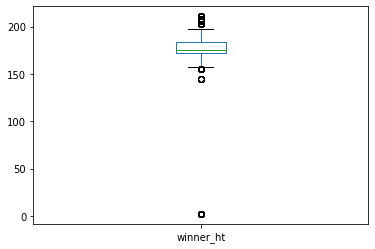

155.125 200.79166666666663
print players with possibly wrong ht
 winner_name        winner_ht
ALBANO OLIVETTI    203.00                         [24.0, 25.0, 27.0, 26.0]
ILIJA VUCIC        145.00                                     [26.0, 25.0]
IVO KARLOVIC       208.00             [39.0, 40.0, 38.0, 37.0, 41.0, 42.0]
JERZY JANOWICZ     203.00                               [26.0, 29.0, 25.0]
JOHN ISNER         206.00       [33.0, 34.0, 32.0, 31.0, 30.0, 35.0, 36.0]
KAMILLA RAKHIMOVA  2.00                           [19.0, 17.0, 16.0, 18.0]
KENNY DE SCHEPPER  203.00                   [30.0, 31.0, 29.0, 28.0, 32.0]
KEVIN ANDERSON     203.00       [32.0, 33.0, 31.0, 30.0, 29.0, 34.0, 35.0]
KURUMI NARA        155.00             [27.0, 26.0, 25.0, 24.0, 28.0, 29.0]
REILLY OPELKA      211.00             [21.0, 22.0, 20.0, 19.0, 18.0, 23.0]
Name: winner_age, dtype: object
Players with correct value ht
 winner_name
ALBANO OLIVETTI      [203.0]
ILIJA VUCIC          [145.0]
IVO KARLOVIC         [2

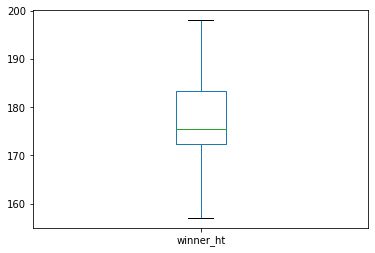

In [60]:
df.winner_ht.plot.box()
plt.show()

L, R = detecting_outliers(df.winner_ht)
print(L, R)
df_outliers = df[(df.winner_ht < L) | (df.winner_ht > R)]
new_df = df.drop(df_outliers.index)

print("print players with possibly wrong ht\n", df_outliers.groupby(['winner_name', 'winner_ht']).winner_age.unique())

df_outliers.loc[df_outliers['winner_name'] == 'Kamilla Rakhimova', 'winner_ht'] = 174 
df_outliers.loc[df_outliers['winner_name'] == 'Ilija Vucic', 'winner_ht'] = 188 
df_outliers.loc[df_outliers['winner_name'] == 'Ivo Karlovic', 'winner_ht'] = 211 

print("Players with correct value ht\n",df_outliers.groupby('winner_name').winner_ht.unique())

new_df.append(df_outliers)
df = new_df
new_df.winner_ht.plot.box()
plt.show()
#df_outliers.groupby('winner_name').winner_ht.unique()
#new_df = df.loc[df['winner_name'] == 'Kamilla Rakhimova']
#new_df.groupby(['winner_name', 'winner_ht']).winner_age.unique()

The same thing we do for losers

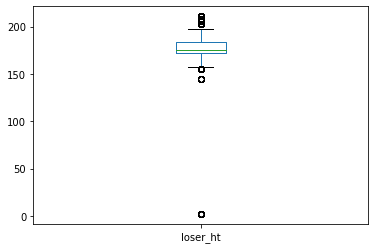

155.125 200.79166666666663
print players with possibly wrong ht
 loser_name         loser_ht
ALBANO OLIVETTI    203.00                        [27.0, 24.0, 25.0, 26.0]
ILIJA VUCIC        145.00                                    [25.0, 26.0]
IVO KARLOVIC       208.00      [39.0, 40.0, 38.0, 37.0, 36.0, 41.0, 42.0]
JERZY JANOWICZ     203.00                              [26.0, 25.0, 29.0]
JOHN ISNER         206.00      [33.0, 34.0, 32.0, 31.0, 30.0, 35.0, 36.0]
KAMILLA RAKHIMOVA  2.00              [18.0, 16.0, 15.0, 14.0, 19.0, 17.0]
KENNY DE SCHEPPER  203.00            [31.0, 32.0, 30.0, 29.0, 28.0, 33.0]
KEVIN ANDERSON     203.00      [32.0, 33.0, 31.0, 30.0, 29.0, 34.0, 35.0]
KURUMI NARA        155.00            [27.0, 26.0, 25.0, 24.0, 28.0, 29.0]
MARCELO MELO       203.00                                          [37.0]
REILLY OPELKA      211.00            [21.0, 22.0, 20.0, 19.0, 18.0, 23.0]
Name: loser_age, dtype: object
Players with correct value ht
 loser_name
ALBANO OLIVETTI     

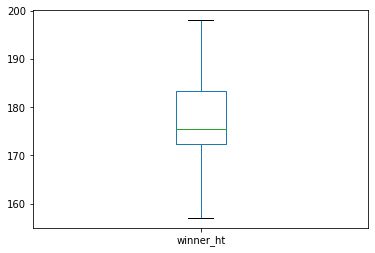

In [61]:
df.loser_ht.plot.box()
plt.show()

L, R = detecting_outliers(df.loser_ht)
print(L, R)
df_outliers = df[(df.loser_ht < L) | (df.loser_ht > R)]
new_df = df.drop(df_outliers.index)

print("print players with possibly wrong ht\n", df_outliers.groupby(['loser_name', 'loser_ht']).loser_age.unique())

df_outliers.loc[df_outliers['loser_name'] == 'Kamilla Rakhimova', 'loser_ht'] = 174 
df_outliers.loc[df_outliers['loser_name'] == 'Ilija Vucic', 'loser_ht'] = 188 
df_outliers.loc[df_outliers['loser_name'] == 'Ivo Karlovic', 'loser_ht'] = 211 

print("Players with correct value ht\n",df_outliers.groupby('loser_name').loser_ht.unique())

new_df.append(df_outliers)
df = new_df
new_df.winner_ht.plot.box()
plt.show()



#### winner_age and loser_age
Ho cambiato solo quelli che hanno un valore molto alto (come età = 95) perché tra gli altri ce ne sono molti che sono comunque corretti

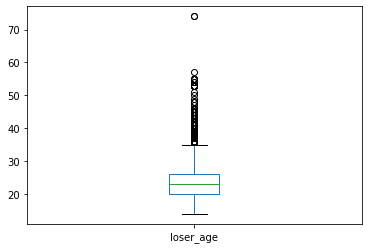

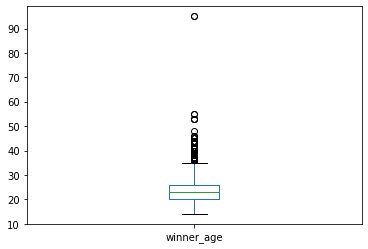

11.0 35.0


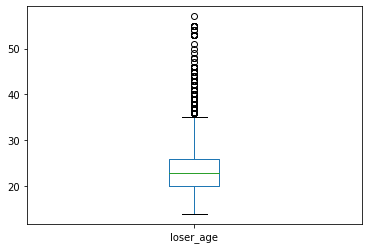

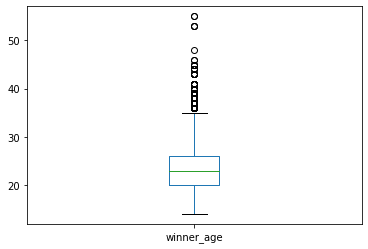

In [62]:
df.loser_age.plot.box() 
plt.show()
df.winner_age.plot.box() 
plt.show()

L, R = detecting_outliers(df.winner_age)
print(L, R)

df.loc[df['winner_age'] > 60, 'winner_age'] = R
df.loc[df['loser_age'] > 60, 'loser_age'] = R

df.loser_age.plot.box() 
plt.show()
df.winner_age.plot.box() 
plt.show()
#df_outliers = df[(df.winner_age < L) | (df.winner_age > R)]
#df_outliers.groupby('winner_age').winner_name.unique()
#df_outliers.winner_age.plot.hist() 
#plt.show()

#### winner_rank and loser_rank

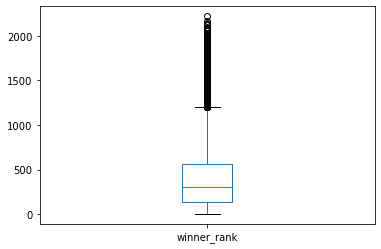

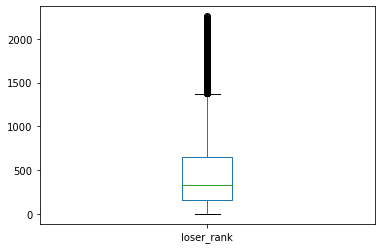

In [63]:
df.winner_rank.plot.box() 
plt.show()
df.loser_rank.plot.box() 
plt.show()

#### winner_rank_point and loser_rank_point

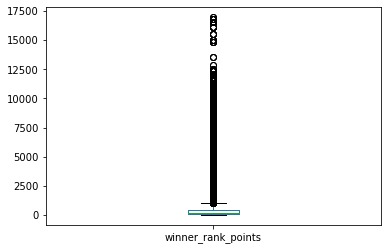

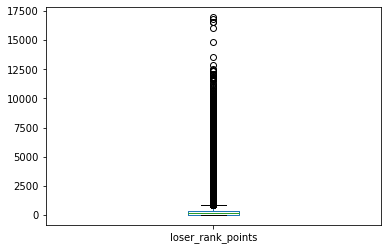

In [64]:
df.winner_rank_points.plot.box() 
plt.show()
df.loser_rank_points.plot.box() 
plt.show()

#### w_ace and l_ace

BEFORE


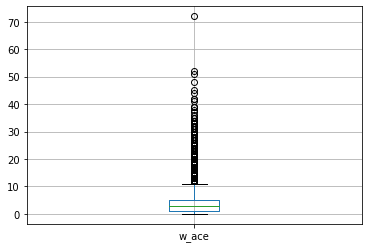

L, R -5.0 11.0
AFTER


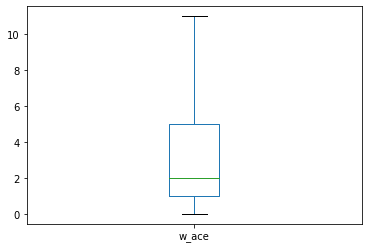

BEFORE


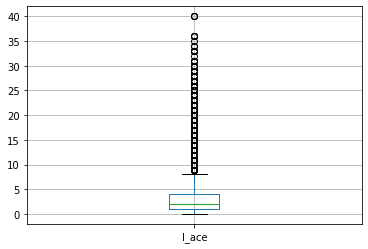

L, R -3.5 8.5
AFTER


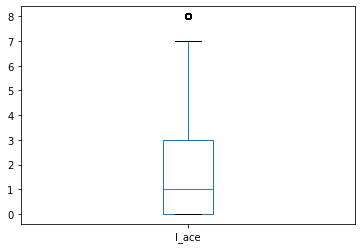

In [65]:
new_df = detecting_outliers_numerical(df, 'w_ace', 'bound')
new_df = detecting_outliers_numerical(df, 'l_ace', 'bound')

#### w_df and l_df

BEFORE


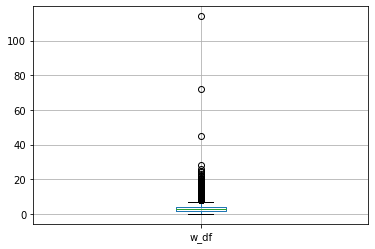

L, R -1.0 7.0
AFTER


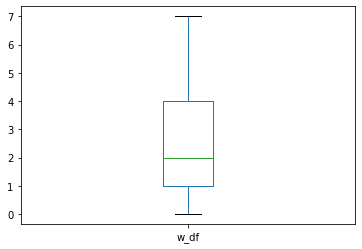

BEFORE


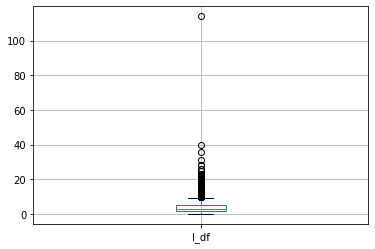

L, R -2.5 9.5
AFTER


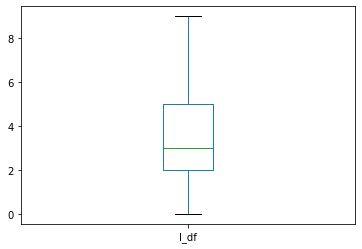

In [66]:
new_df = detecting_outliers_numerical(df, 'w_df', 'bound')
new_df = detecting_outliers_numerical(df, 'l_df', 'bound')

#### w_svpt and l_svpt

BEFORE


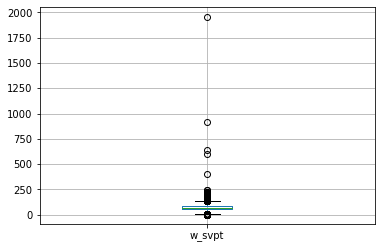

L, R 6.0 134.0
facciamo la mediana 62.0
AFTER


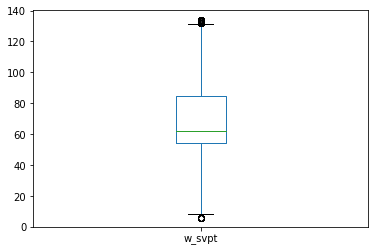

BEFORE


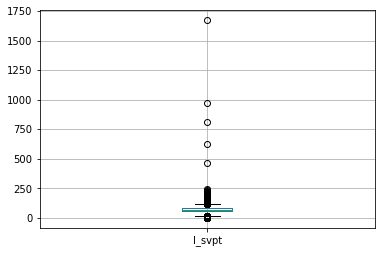

L, R 20.5 120.5
facciamo la mediana 67.0
AFTER


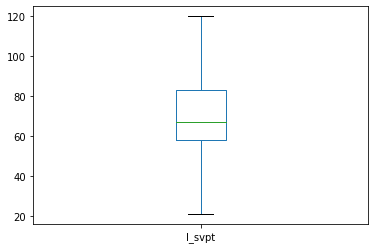

In [67]:
#new_df = detecting_outliers_numerical(df, 'w_svpt')
new_df = detecting_outliers_numerical(df, 'w_svpt', 'median')
new_df = detecting_outliers_numerical(df, 'l_svpt', 'median')

#### w_1stIn and l_1stIn

BEFORE


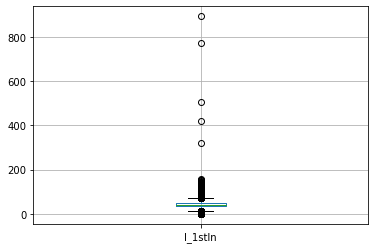

L, R 13.5 73.5
facciamo la mediana 41.0
AFTER


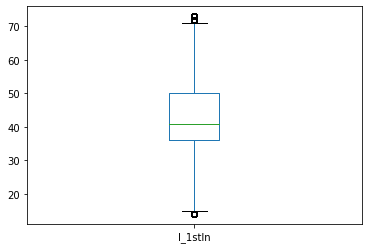

In [68]:
new_df = detecting_outliers_numerical(df, 'l_1stIn', 'median')

#### w_1stWon w_2stWon and l_1stWon l_2stWon  

BEFORE


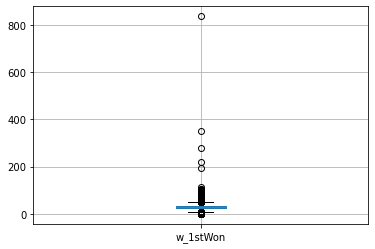

L, R 10.0 50.0
facciamo la mediana 29.0
AFTER


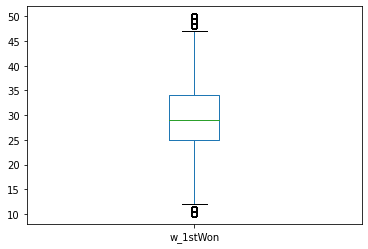

BEFORE


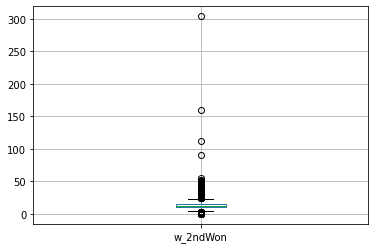

L, R 3.5 23.5
facciamo la mediana 13.0
AFTER


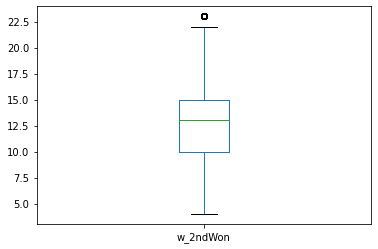

In [69]:
new_df = detecting_outliers_numerical(df, 'w_1stWon', 'median')
new_df = detecting_outliers_numerical(df, 'w_2ndWon', 'median')

BEFORE


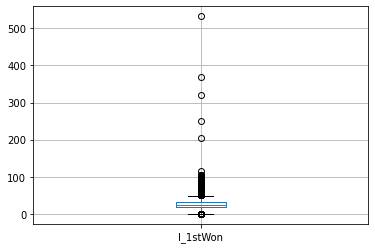

L, R 1.0 49.0
facciamo la mediana 24.0
AFTER


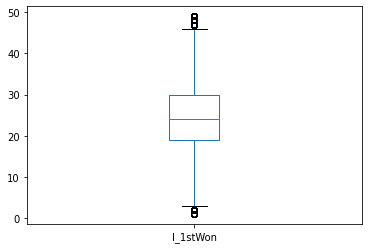

BEFORE


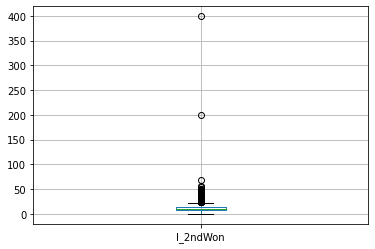

L, R -1.0 23.0
facciamo la mediana 11.0
AFTER


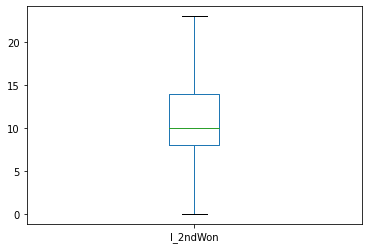

In [70]:
new_df = detecting_outliers_numerical(df, 'l_1stWon', 'median')
new_df = detecting_outliers_numerical(df, 'l_2ndWon', 'median')

#### w_bpSaved w_bpFaced and l_bpSaved l_bpFaced

BEFORE


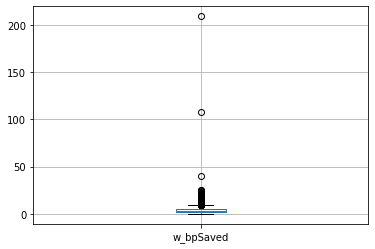

L, R -2.5 9.5
facciamo la mediana 3.0
AFTER


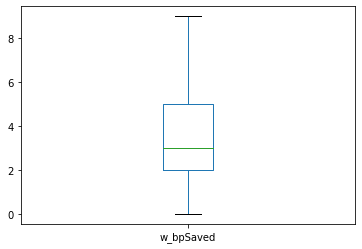

BEFORE


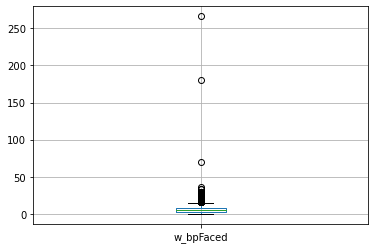

L, R -4.5 15.5
facciamo la mediana 6.0
AFTER


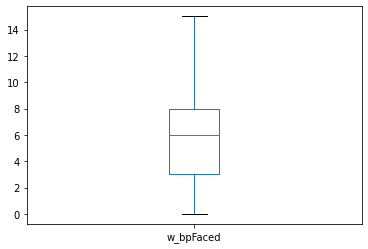

In [71]:
new_df = detecting_outliers_numerical(df, 'w_bpSaved', 'median')
new_df = detecting_outliers_numerical(df, 'w_bpFaced', 'median')

BEFORE


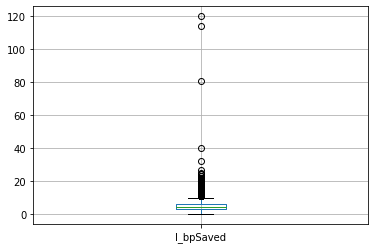

L, R -1.5 10.5
facciamo la mediana 4.0
AFTER


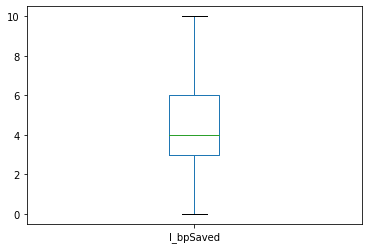

BEFORE


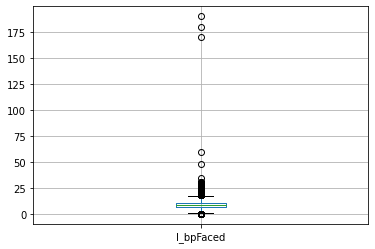

L, R 1.0 17.0
facciamo la mediana 9.0
AFTER


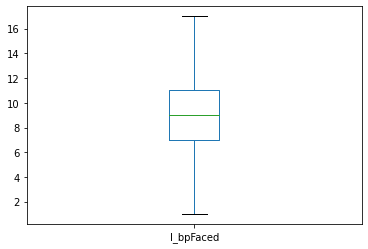

In [72]:
new_df = detecting_outliers_numerical(df, 'l_bpSaved', 'median')
new_df = detecting_outliers_numerical(df, 'l_bpFaced', 'median')

#### winner_name and loser_name

To discover if a player's name is an outlier we must count the name's occurences both in winner_name and loser_name, if its occurrences are very low then we consider it as an outlier. We assume this, also because if we have few statistics about a player then we don't have the sufficient known about him to costruct an exaustive profile. 

winner_names = df.groupby(df.winner_name, as_index = False).size()
winner_names= pd.DataFrame(winner_names)
winner_names.reset_index(level=0, inplace=True)

loser_names = df.groupby(df.loser_name, as_index = False).size()
loser_names= pd.DataFrame(loser_names)
loser_names.reset_index(level=0, inplace=True)

winner_names.rename( columns={'winner_name' : 'name', 0 :'freq'}, inplace = True)
loser_names.rename( columns={'loser_name' : 'name', 0 :'freq'}, inplace = True)
#print(winner_names, loser_names)
names = pd.concat([winner_names, loser_names])
#names = pd.DataFrame(names)
names = names.groupby(names.name, as_index = False).sum()
names = pd.DataFrame(names)
#print(names)
#names = names.groupby(names, as_index = False).size()
#names.set_axis(['name', 'freq'])
outliers_name = names[names['freq']<3]
outliers_name

# Write on CSV

In [73]:
df.to_csv('dataset/matches_datacleaning.csv')